# Setting Up Environment

In [1]:
import math, os, re, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, AlphaDropout
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.callbacks import EarlyStopping

tqdm.pandas()
tf.random.set_seed(42)

%matplotlib inline

os.listdir()

['__notebook__.ipynb']

In [2]:
print(tf.__version__)

2.4.1


# Data Preparation

In [3]:
raw_data = pd.read_csv('../input/bt4222-project/modelling_dataset.csv')
raw_data = pd.concat([raw_data.pop('Unit Price ($ PSM)'), raw_data], axis=1)

raw_data

Unit Price ($ PSM)  Area (SQM)  Floor Number    PPI  \
0                  6316.0        95.0           1.0  124.3   
1                 13833.0       138.0           1.0  124.3   
2                  8990.0        99.0          10.0  124.3   
3                  6306.0       111.0           6.0  124.3   
4                 13934.0       122.0          10.0  124.3   
...                   ...         ...           ...    ...   
54669              8229.0       192.0           4.0  153.3   
54670              7838.0       111.0          14.0  153.3   
54671             13028.0       142.0          14.0  153.3   
54672             13931.0        58.0           6.0  153.3   
54673             14379.0       153.0           1.0  153.3   

       Average Cases Per Year  Nearest Primary School  \
0                          33              705.752731   
1                          58             1233.947139   
2                          50             1039.586179   
3                          33              509.516515   
4                          58             1253.733260   
...                       ...                     ...   
54669                      66              526.868822   
54670                      66              535.286185   
54671                     133             2075.609094   
54672                      51              397.651025   
54673                      85             3006.785990   

       nearest_station_distance  Remaining Lease  Ang Mo Kio  Bedok  ...  \
0                   1207.822015             87.0           0      0  ...   
1                    768.529003             88.0           0      0  ...   
2                    816.818037             80.0           0      0  ...   
3                    501.364218             80.0           0      0  ...   
4                    554.491114             88.0           0      0  ...   
...                         ...              ...         ...    ...  ...   
54669                464.021930             76.0           0      0  ...   
54670                490.669867             80.0           0      0  ...   
54671                600.145285             72.0           0      0  ...   
54672                539.116552             91.0           0      0  ...   
54673               3043.879677             83.0           0      0  ...   

       Yishun  BLUE  BROWN  GREEN  LRT  PURPLE  RED  YELLOW  Apartment  \
0           0     0      0      0    0       0    0       0          0   
1           0     0      0      0    0       1    0       0          0   
2           0     0      0      1    0       0    0       0          0   
3           1     0      0      0    0       0    1       0          0   
4           0     0      0      0    0       1    0       0          0   
...       ...   ...    ...    ...  ...     ...  ...     ...        ...   
54669       0     0      0      0    1       0    0       0          0   
54670       0     0      0      0    1       1    0       0          0   
54671       0     0      0      0    0       0    0       1          0   
54672       0     1      0      0    0       0    0       0          0   
54673       0     0      0      0    0       0    0       0          0   

       Executive Condominium  
0                          0  
1                          0  
2                          0  
3                          0  
4                          0  
...                      ...  
54669                      0  
54670                      1  
54671                      0  
54672                      0  
54673                      0  

[54674 rows x 53 columns]

# Train-Test Split

In [4]:
# Perform 70/30 train_test split sequentially
X = raw_data.iloc[:,1:].copy()
y = raw_data.iloc[:,0:1].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    random_state=42)
X_train

Area (SQM)  Floor Number    PPI  Average Cases Per Year  \
11187       129.0           9.0  139.2                      66   
18593        66.0          13.0  142.3                      63   
27013        61.0          58.0  137.7                      85   
39116       105.0          18.0  141.6                      66   
6042        111.0          37.0  132.6                      60   
...           ...           ...    ...                     ...   
44732       107.0           3.0  145.2                      36   
54343        66.0           2.0  153.3                      64   
38158        74.0           3.0  141.6                     142   
860          91.0          14.0  124.3                     133   
15795        93.0          14.0  141.6                      63   

       Nearest Primary School  nearest_station_distance  Remaining Lease  \
11187              313.319878               1514.605671             85.0   
18593              408.305136               1517.388799             84.0   
27013             1529.338980                148.651892             86.0   
39116              270.671774                225.750354             86.0   
6042               339.216214                258.201238             87.0   
...                       ...                       ...              ...   
44732              102.333066                622.895879             73.0   
54343              414.799433                805.354104             87.0   
38158              774.750823                466.130105             76.0   
860                658.187930                310.779399             83.0   
15795             1012.110023               1574.767976             80.0   

       Ang Mo Kio  Bedok  Bishan  ...  Yishun  BLUE  BROWN  GREEN  LRT  \
11187           0      0       0  ...       0     0      0      0    0   
18593           0      1       0  ...       0     0      0      0    0   
27013           0      0       0  ...       0     1      0      1    0   
39116           0      0       0  ...       0     0      0      0    1   
6042            0      0       0  ...       0     0      0      1    0   
...           ...    ...     ...  ...     ...   ...    ...    ...  ...   
44732           1      0       0  ...       0     0      0      0    0   
54343           0      0       0  ...       0     0      1      0    0   
38158           0      0       0  ...       0     1      0      0    0   
860             0      0       0  ...       0     0      0      1    0   
15795           0      1       0  ...       0     0      0      0    0   

       PURPLE  RED  YELLOW  Apartment  Executive Condominium  
11187       0    0       0          0                      1  
18593       0    0       0          0                      0  
27013       0    1       1          1                      0  
39116       1    0       0          0                      0  
6042        0    0       0          0                      0  
...       ...  ...     ...        ...                    ...  
44732       0    1       0          0                      0  
54343       0    1       0          0                      0  
38158       1    0       0          0                      0  
860         0    0       1          0                      0  
15795       0    0       0          0                      0  

[38271 rows x 52 columns]

# Feature Scaling

In [5]:
def all_transform(X_train, X_test):
    all_features = list(X_train.columns)

    standardScale_vars = ['Area (SQM)',
                          'Floor Number',
                          'PPI',
                          'Average Cases Per Year',
                          'Nearest Primary School',
                          'nearest_station_distance']

    minMax_vars = ['Remaining Lease']

    remaining_features = [x for x in all_features if x not in standardScale_vars and x not in minMax_vars]

    s_scaler = StandardScaler()
    mm_scaler = MinMaxScaler()

    s_scaled = pd.DataFrame(s_scaler.fit_transform(X_train.loc[:, standardScale_vars].copy()), columns=standardScale_vars, index=X_train.index)
    mm_scaled = pd.DataFrame(mm_scaler.fit_transform(X_train.loc[:, minMax_vars].copy()), columns=minMax_vars, index=X_train.index)

    X_train = pd.concat([s_scaled, 
                         mm_scaled, 
                         X_train.loc[:, remaining_features].copy()], axis=1)

    s_scaled = pd.DataFrame(s_scaler.transform(X_test.loc[:, standardScale_vars].copy()), columns=standardScale_vars, index=X_test.index)
    mm_scaled = pd.DataFrame(mm_scaler.transform(X_test.loc[:, minMax_vars].copy()), columns=minMax_vars, index=X_test.index)

    X_test = pd.concat([s_scaled, 
                        mm_scaled, 
                        X_test.loc[:, remaining_features].copy()], axis=1)
    
    return X_train, X_test

In [6]:
X_train, X_test = all_transform(X_train, X_test)
X_train

Area (SQM)  Floor Number       PPI  Average Cases Per Year  \
11187    0.291530     -0.109176 -0.236229                0.243812   
18593   -1.125873      0.371998  0.210453                0.125051   
27013   -1.238366      5.785202 -0.452365                0.995966   
39116   -0.248433      0.973465  0.109589                0.243812   
6042    -0.113442      3.259040 -1.187229                0.006290   
...           ...           ...       ...                     ...   
44732   -0.203436     -0.830937  0.628316               -0.943799   
54343   -1.125873     -0.951230  1.795452                0.164638   
38158   -0.945886     -0.830937  0.109589                3.252428   
860     -0.563412      0.492291 -2.383183                2.896144   
15795   -0.518415      0.492291  0.109589                0.125051   

       Nearest Primary School  nearest_station_distance  Remaining Lease  \
11187               -0.771624                  1.226898         0.745098   
18593               -0.570640                  1.231468         0.725490   
27013                1.801408                 -1.015899         0.764706   
39116               -0.861865                 -0.889309         0.764706   
6042                -0.716828                 -0.836027         0.784314   
...                       ...                       ...              ...   
44732               -1.218061                 -0.237225         0.509804   
54343               -0.556898                  0.062359         0.784314   
38158                0.204740                 -0.494623         0.568627   
860                 -0.041901                 -0.749697         0.705882   
15795                0.706979                  1.325680         0.647059   

       Ang Mo Kio  Bedok  Bishan  ...  Yishun  BLUE  BROWN  GREEN  LRT  \
11187           0      0       0  ...       0     0      0      0    0   
18593           0      1       0  ...       0     0      0      0    0   
27013           0      0       0  ...       0     1      0      1    0   
39116           0      0       0  ...       0     0      0      0    1   
6042            0      0       0  ...       0     0      0      1    0   
...           ...    ...     ...  ...     ...   ...    ...    ...  ...   
44732           1      0       0  ...       0     0      0      0    0   
54343           0      0       0  ...       0     0      1      0    0   
38158           0      0       0  ...       0     1      0      0    0   
860             0      0       0  ...       0     0      0      1    0   
15795           0      1       0  ...       0     0      0      0    0   

       PURPLE  RED  YELLOW  Apartment  Executive Condominium  
11187       0    0       0          0                      1  
18593       0    0       0          0                      0  
27013       0    1       1          1                      0  
39116       1    0       0          0                      0  
6042        0    0       0          0                      0  
...       ...  ...     ...        ...                    ...  
44732       0    1       0          0                      0  
54343       0    1       0          0                      0  
38158       1    0       0          0                      0  
860         0    0       1          0                      0  
15795       0    0       0          0                      0  

[38271 rows x 52 columns]

# Train-Validation Split

In [7]:
# Train-Validation Split
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, 
                                                    test_size=0.2,
                                                    shuffle=True, 
                                                    random_state=42)
X_train

Area (SQM)  Floor Number       PPI  Average Cases Per Year  \
9079    -0.338427     -0.830937 -0.510002               -0.072884   
50500    0.426521     -0.349763  1.147043                2.896144   
42324   -0.068445      1.334345  0.757998               -1.022973   
33190    2.496380      0.612585 -1.028729                0.006290   
12391   -0.023448     -0.590350 -0.005684               -0.864625   
...           ...           ...       ...                     ...   
40185   -0.225935      0.371998  0.757998                0.243812   
46425    0.336527      0.612585  1.319952                0.243812   
33159   -0.068445     -0.951230 -1.028729               -0.943799   
46563   -0.810895      0.492291  1.319952               -0.825038   
22428    1.011481      1.815519  1.161452               -1.022973   

       Nearest Primary School  nearest_station_distance  Remaining Lease  \
9079                -0.337170                 -0.184168         0.843137   
50500               -0.084831                 -0.944134         0.568627   
42324               -0.477199                 -0.716844         0.882353   
33190                0.510938                  0.544301         0.862745   
12391               -0.737739                  0.647023         0.803922   
...                       ...                       ...              ...   
40185               -0.729890                  0.154151         0.862745   
46425                0.209585                 -0.999626         0.725490   
33159               -1.148569                 -0.292310         0.549020   
46563                0.254966                 -0.725711         0.882353   
22428                0.561305                  0.346104         0.901961   

       Ang Mo Kio  Bedok  Bishan  ...  Yishun  BLUE  BROWN  GREEN  LRT  \
9079            0      0       0  ...       0     0      0      0    0   
50500           0      0       0  ...       0     0      0      1    0   
42324           0      0       1  ...       0     0      0      0    0   
33190           0      0       0  ...       0     0      0      0    0   
12391           0      0       0  ...       0     0      0      0    0   
...           ...    ...     ...  ...     ...   ...    ...    ...  ...   
40185           0      0       0  ...       0     0      0      0    0   
46425           0      0       0  ...       0     0      0      0    0   
33159           1      0       0  ...       0     0      0      0    0   
46563           0      0       0  ...       0     0      0      0    0   
22428           0      0       1  ...       0     0      0      0    0   

       PURPLE  RED  YELLOW  Apartment  Executive Condominium  
9079        1    0       1          0                      0  
50500       0    0       1          1                      0  
42324       0    1       1          0                      0  
33190       0    0       0          0                      0  
12391       0    0       0          0                      0  
...       ...  ...     ...        ...                    ...  
40185       1    0       0          0                      0  
46425       1    0       0          0                      0  
33159       0    1       0          0                      0  
46563       0    0       1          0                      0  
22428       0    1       1          0                      0  

[30616 rows x 52 columns]

In [8]:
print(X_train.shape)
print(y_train.shape)
print(X_eval.shape)
print(y_eval.shape)
print(X_test.shape)
print(y_test.shape)

(30616, 52)
(30616, 1)
(7655, 52)
(7655, 1)
(16403, 52)
(16403, 1)


# Model Building & Training

In [9]:
def two_layer_nn(nodes=[64, 128], batch_norm=True, drop_rate=0.5):
    # Model building
    n_features = X_train.shape[1]
    
    model = Sequential()
    model.add(Dense(nodes[0], activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
    
    if batch_norm:
        model.add(BatchNormalization())
    else:
        model.add(Dropout(drop_rate))

    model.add(Dense(nodes[1], activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(drop_rate))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse')
    print(model.summary(), '\n')

    early_stop = EarlyStopping(monitor='val_loss', patience=10)

    history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.2, callbacks=[early_stop])
    
    # Model Errors
    plt.rcParams['figure.figsize'] = 12,8

    plt.title('Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()

    plt.show()
    plt.clf()
    
    # Model Evaluation
    y_train_pred = model.predict(X_train)
    y_eval_pred = model.predict(X_eval)
    y_test_pred = model.predict(X_test)
    
    train_rmse = np.sqrt(MeanSquaredError()(y_train, y_train_pred).numpy())
    train_mape = MeanAbsolutePercentageError()(y_train, y_train_pred).numpy()
    
    eval_rmse = np.sqrt(MeanSquaredError()(y_eval, y_eval_pred).numpy())
    eval_mape = MeanAbsolutePercentageError()(y_eval, y_eval_pred).numpy()
    
    test_rmse = np.sqrt(MeanSquaredError()(y_test, y_test_pred).numpy())
    test_mape = MeanAbsolutePercentageError()(y_test, y_test_pred).numpy()
    
    print('Train RMSE: %.3f, Train MAPE: %.3f' % (train_rmse, train_mape), '\n')
    print('Val RMSE: %.3f, Val MAPE: %.3f' % (eval_rmse, eval_mape), '\n')
    print('Test RMSE: %.3f, Test MAPE: %.3f' % (test_rmse, test_mape), '\n')
    
    return train_rmse, eval_rmse, test_rmse, train_mape, eval_mape, test_mape


In [10]:
def model_training(batch_norm=True, drop_rate=0.5):
    # searching for best node combinations
    node_combinations = [(2**i, 2**(i+1)) for i in range(3,9)] + [(2**i, 2**i) for i in range(3,10)] + [(2**(i+1), 2**i) for i in range(3,9)]
    
    df_two_layer_nn = []

    for i,j in node_combinations:
        train_rmse, eval_rmse, test_rmse, train_mape, eval_mape, test_mape = two_layer_nn(nodes=[i, j], 
                                                                                          batch_norm=batch_norm, 
                                                                                          drop_rate=drop_rate)

        df_two_layer_nn.append({'n_layer1': i,
                                'n_layer2': j,
                                'batch_norm': batch_norm,
                                'drop_rate': drop_rate,
                                'train_rmse': train_rmse,
                                'eval_rmse': eval_rmse,
                                'test_rmse': test_rmse,
                                'train_mape': train_mape,
                                'eval_mape': eval_mape,
                                'test_mape': test_mape})
    
    return pd.DataFrame(df_two_layer_nn)

# Collecting Error Metrics (for comparison)

  0%|          | 0/6 [00:00<?, ?it/s]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 424       
_________________________________________________________________
batch_normalization (BatchNo (None, 8)                 32        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                144       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 617
Trainable params: 601
Non-trainable params: 16
_________________________________________________________________
None 

Epoch 1/500
766/766 [==============================] - 2s 2ms/step - loss: 144568498.8370 - val_loss: 139457584.0000

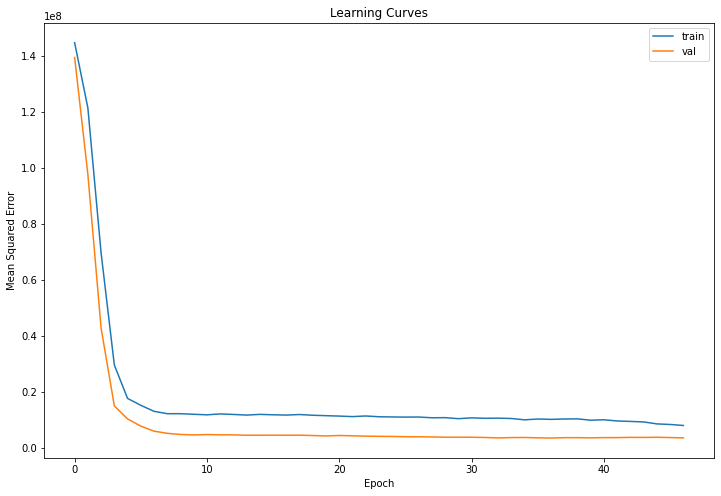

Train RMSE: 1836.116, Train MAPE: 11.374 

Val RMSE: 1800.720, Val MAPE: 11.347 

Test RMSE: 1817.247, Test MAPE: 11.435 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                848       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dense_4 (Dense)              (None, 32)                544       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,489
Trainable params: 1,457
Non-trainable params: 32
____________________________________________________________

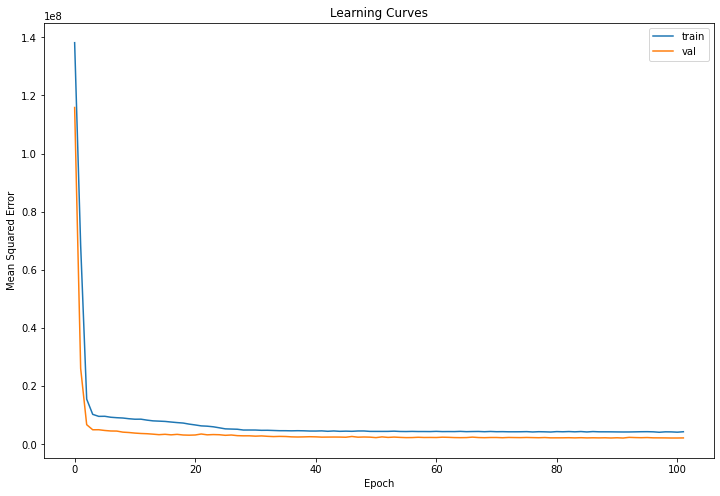

Train RMSE: 1419.067, Train MAPE: 8.497 

Val RMSE: 1415.617, Val MAPE: 8.395 

Test RMSE: 1436.650, Test MAPE: 8.639 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                1696      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,001
Trainable params: 3,937
Non-trainable params: 64
_______________________________________________________________

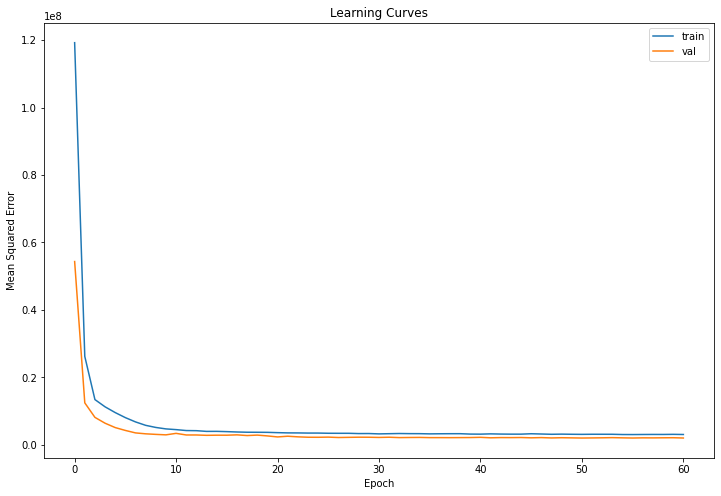

Train RMSE: 1377.035, Train MAPE: 7.955 

Val RMSE: 1416.843, Val MAPE: 8.094 

Test RMSE: 1375.265, Test MAPE: 8.143 

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                3392      
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
dense_10 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 12,097
Trainable params: 11,969
Non-trainable params: 128
____________________________________________________________

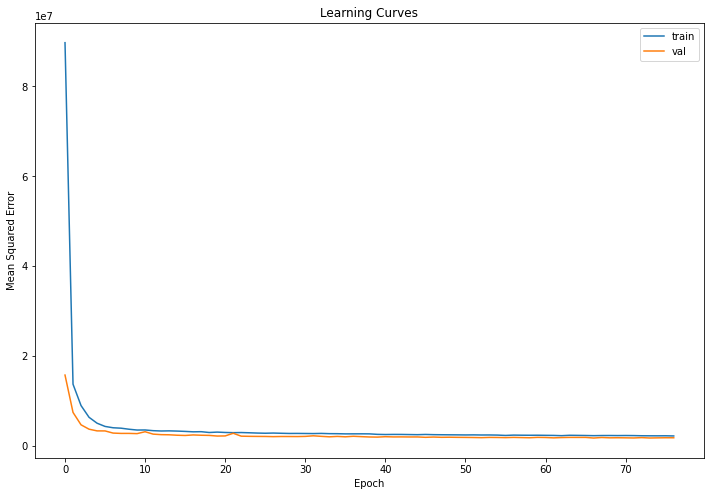

Train RMSE: 1309.983, Train MAPE: 7.367 

Val RMSE: 1345.398, Val MAPE: 7.507 

Test RMSE: 1310.690, Test MAPE: 7.570 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 128)               6784      
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
dense_13 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 257       
Total params: 40,577
Trainable params: 40,321
Non-trainable params: 256
____________________________________________________________

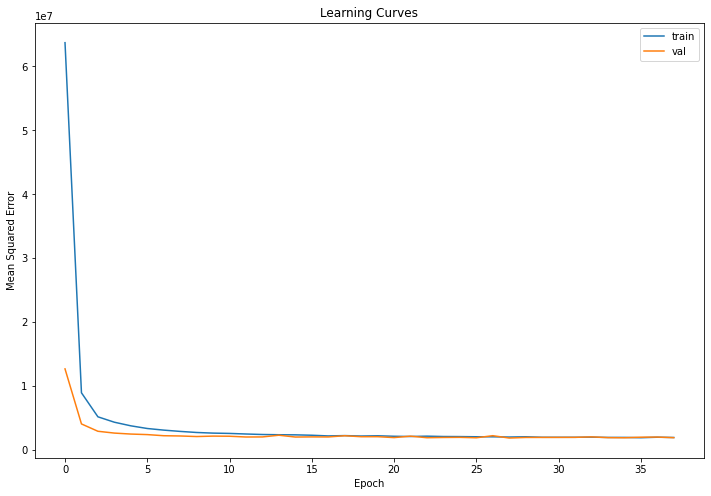

Train RMSE: 1322.262, Train MAPE: 7.233 

Val RMSE: 1475.795, Val MAPE: 7.453 

Test RMSE: 1442.844, Test MAPE: 7.585 

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 256)               13568     
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
dense_16 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 513       
Total params: 146,689
Trainable params: 146,177
Non-trainable params: 512
__________________________________________________________

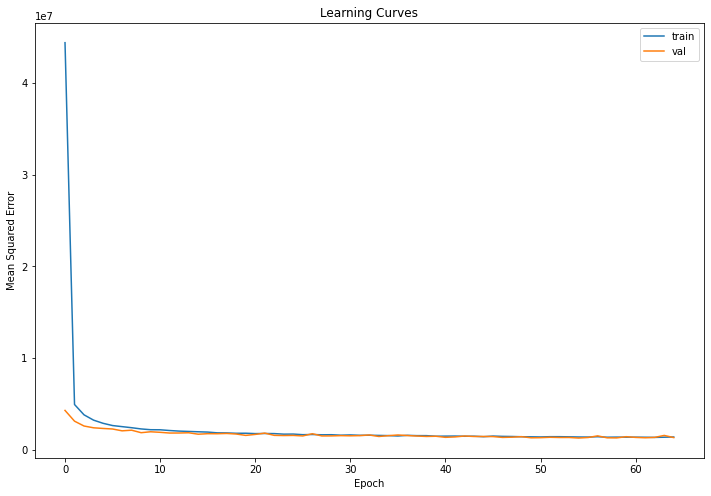

Train RMSE: 1086.639, Train MAPE: 6.172 

Val RMSE: 1145.094, Val MAPE: 6.452 

Test RMSE: 1154.692, Test MAPE: 6.488 

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 8)                 424       
_________________________________________________________________
batch_normalization_6 (Batch (None, 8)                 32        
_________________________________________________________________
dense_19 (Dense)             (None, 8)                 72        
_________________________________________________________________
dropout_6 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 9         
Total params: 537
Trainable params: 521
Non-trainable params: 16
_________________________________________________________________
N

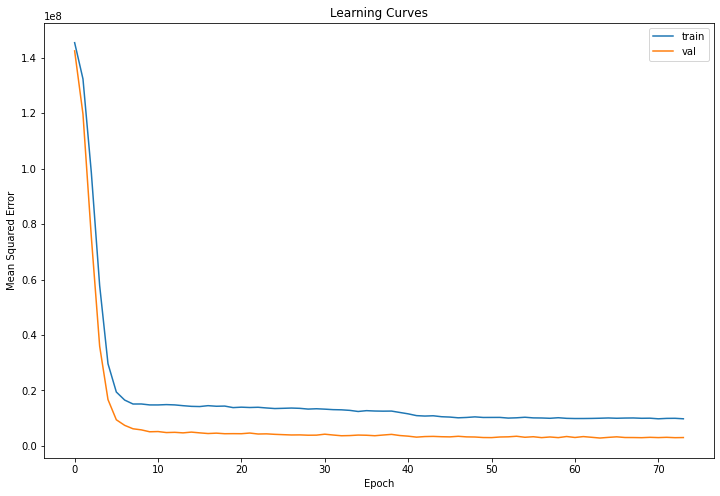

Train RMSE: 1692.917, Train MAPE: 9.887 

Val RMSE: 1659.625, Val MAPE: 9.852 

Test RMSE: 1685.263, Test MAPE: 9.946 

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 16)                848       
_________________________________________________________________
batch_normalization_7 (Batch (None, 16)                64        
_________________________________________________________________
dense_22 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 17        
Total params: 1,201
Trainable params: 1,169
Non-trainable params: 32
_______________________________________________________________

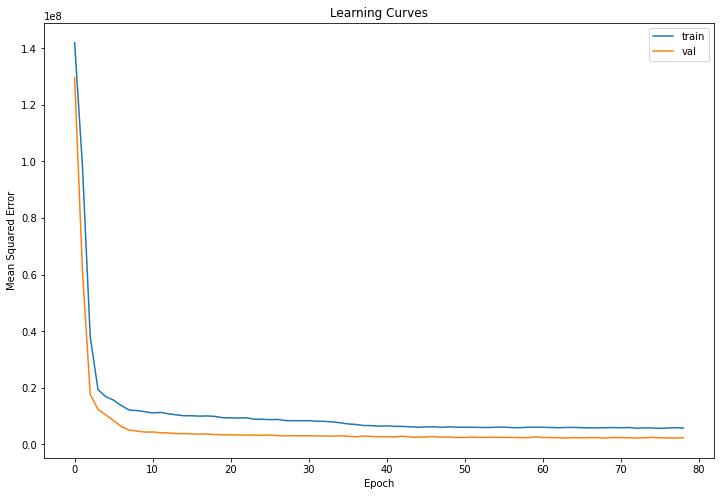

Train RMSE: 1488.485, Train MAPE: 8.671 

Val RMSE: 1488.369, Val MAPE: 8.752 

Test RMSE: 1494.271, Test MAPE: 8.837 

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 32)                1696      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32)                128       
_________________________________________________________________
dense_25 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 33        
Total params: 2,913
Trainable params: 2,849
Non-trainable params: 64
_______________________________________________________________

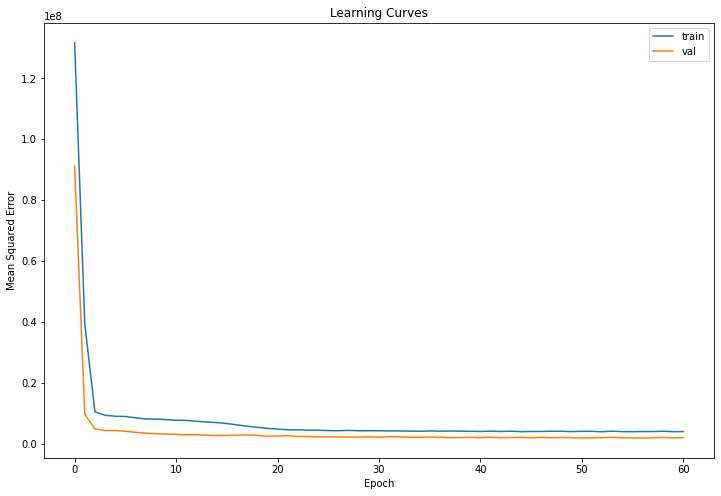

Train RMSE: 1377.338, Train MAPE: 8.129 

Val RMSE: 1438.040, Val MAPE: 8.213 

Test RMSE: 1409.917, Test MAPE: 8.290 

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 64)                3392      
_________________________________________________________________
batch_normalization_9 (Batch (None, 64)                256       
_________________________________________________________________
dense_28 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 65        
Total params: 7,873
Trainable params: 7,745
Non-trainable params: 128
______________________________________________________________

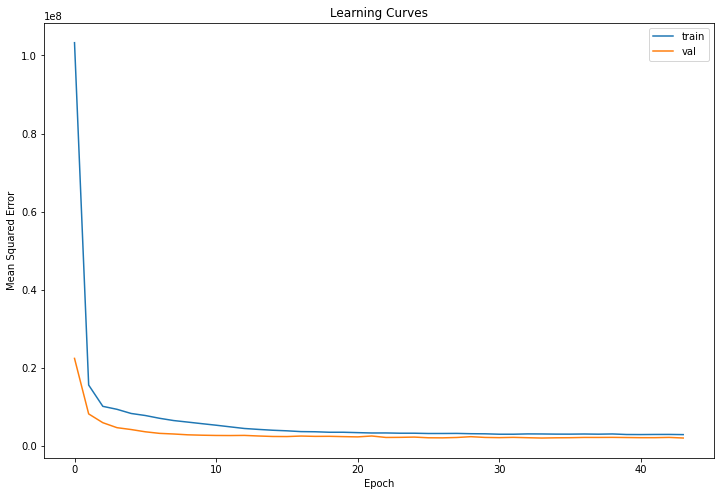

Train RMSE: 1365.239, Train MAPE: 8.050 

Val RMSE: 1374.573, Val MAPE: 8.098 

Test RMSE: 1366.709, Test MAPE: 8.093 

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 128)               6784      
_________________________________________________________________
batch_normalization_10 (Batc (None, 128)               512       
_________________________________________________________________
dense_31 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 129       
Total params: 23,937
Trainable params: 23,681
Non-trainable params: 256
___________________________________________________________

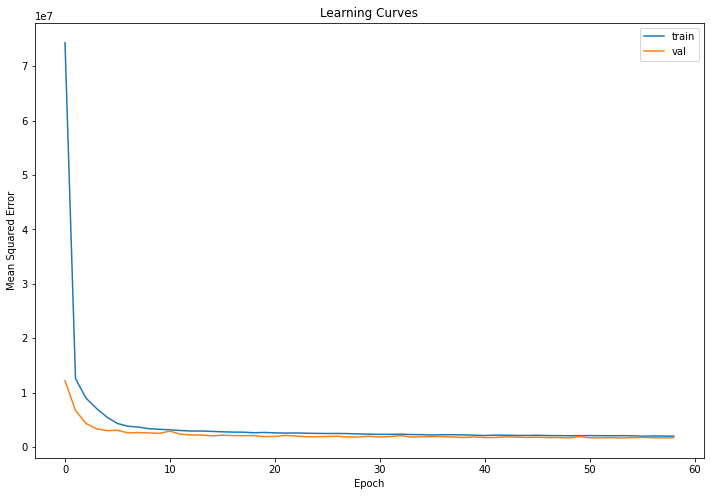

Train RMSE: 1260.554, Train MAPE: 6.770 

Val RMSE: 1409.829, Val MAPE: 6.947 

Test RMSE: 1436.937, Test MAPE: 7.068 

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 256)               13568     
_________________________________________________________________
batch_normalization_11 (Batc (None, 256)               1024      
_________________________________________________________________
dense_34 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 257       
Total params: 80,641
Trainable params: 80,129
Non-trainable params: 512
___________________________________________________________

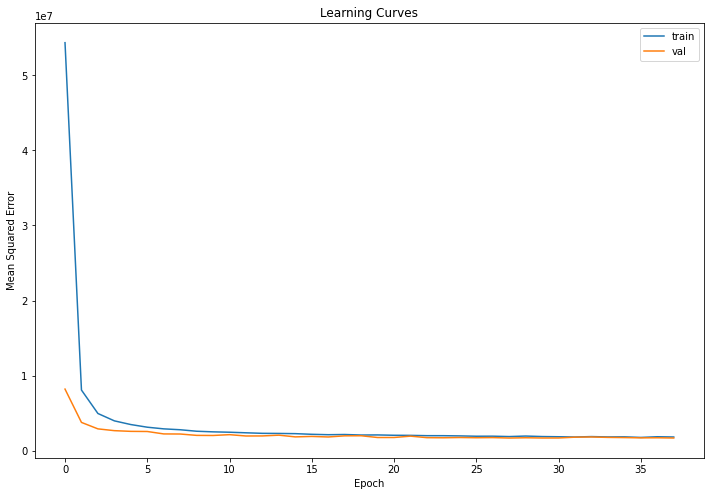

Train RMSE: 1250.527, Train MAPE: 6.843 

Val RMSE: 1299.414, Val MAPE: 7.002 

Test RMSE: 1284.343, Test MAPE: 7.172 

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 512)               27136     
_________________________________________________________________
batch_normalization_12 (Batc (None, 512)               2048      
_________________________________________________________________
dense_37 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 513       
Total params: 292,353
Trainable params: 291,329
Non-trainable params: 1,024
_______________________________________________________

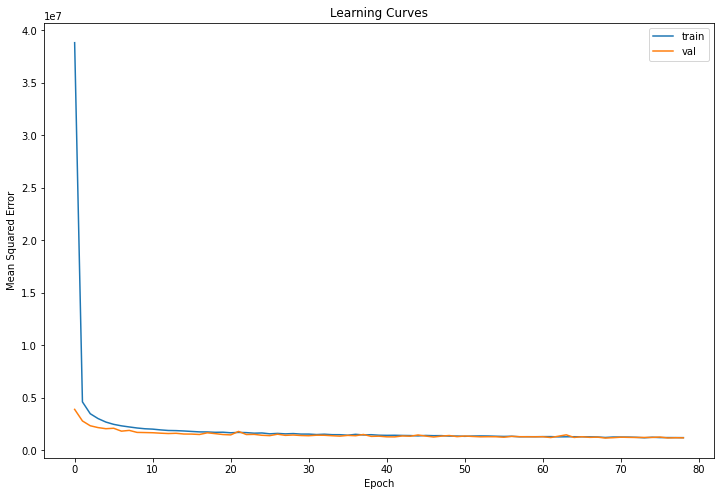

Train RMSE: 973.708, Train MAPE: 5.576 

Val RMSE: 1036.633, Val MAPE: 6.014 

Test RMSE: 1075.836, Test MAPE: 6.080 

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 16)                848       
_________________________________________________________________
batch_normalization_13 (Batc (None, 16)                64        
_________________________________________________________________
dense_40 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_13 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 9         
Total params: 1,057
Trainable params: 1,025
Non-trainable params: 32
_______________________________________________________________

Train RMSE: 1529.609, Train MAPE: 8.870 

Val RMSE: 1510.089, Val MAPE: 8.845 

Test RMSE: 1523.615, Test MAPE: 8.944 

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 32)                1696      
_________________________________________________________________
batch_normalization_14 (Batc (None, 32)                128       
_________________________________________________________________
dense_43 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_14 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 17        
Total params: 2,369
Trainable params: 2,305
Non-trainable params: 64
______________________________________________________________

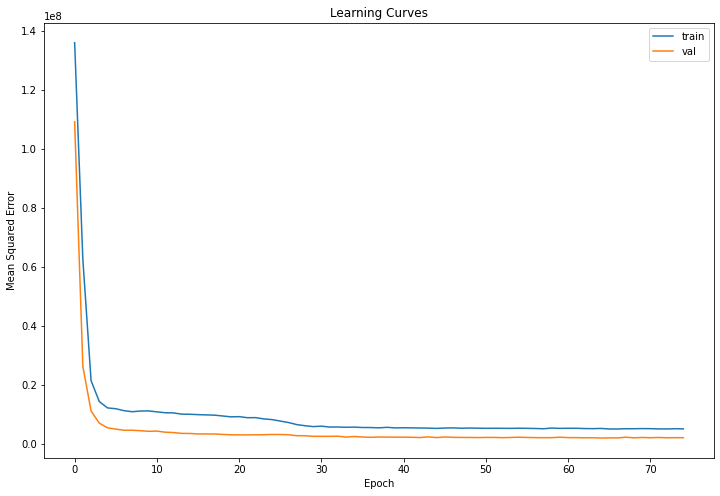

Train RMSE: 1394.367, Train MAPE: 8.220 

Val RMSE: 1433.502, Val MAPE: 8.244 

Test RMSE: 1421.757, Test MAPE: 8.373 

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 64)                3392      
_________________________________________________________________
batch_normalization_15 (Batc (None, 64)                256       
_________________________________________________________________
dense_46 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_15 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 33        
Total params: 5,761
Trainable params: 5,633
Non-trainable params: 128
_____________________________________________________________

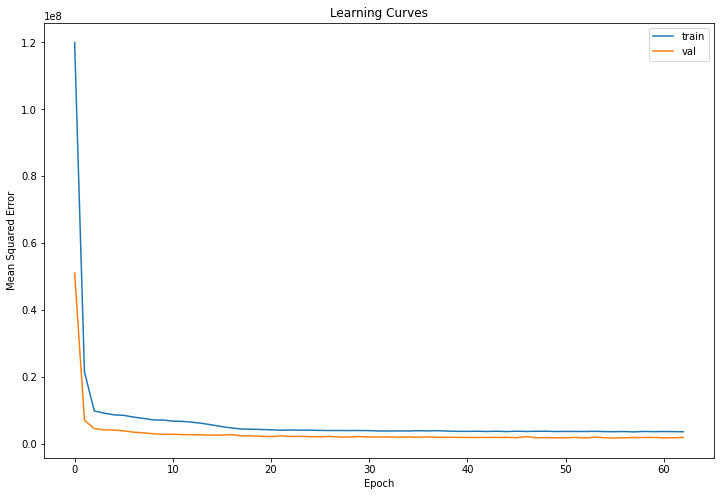

Train RMSE: 1378.782, Train MAPE: 7.847 

Val RMSE: 1354.838, Val MAPE: 7.832 

Test RMSE: 1370.574, Test MAPE: 7.965 

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 128)               6784      
_________________________________________________________________
batch_normalization_16 (Batc (None, 128)               512       
_________________________________________________________________
dense_49 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 65        
Total params: 15,617
Trainable params: 15,361
Non-trainable params: 256
___________________________________________________________

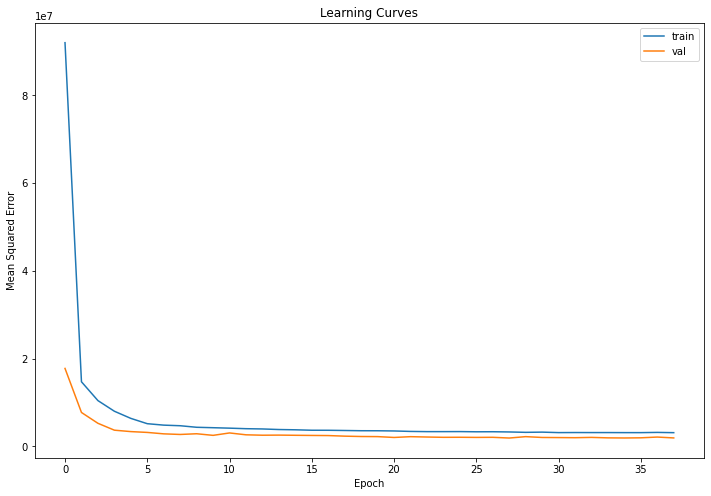

Train RMSE: 1329.163, Train MAPE: 7.418 

Val RMSE: 1395.388, Val MAPE: 7.591 

Test RMSE: 1340.543, Test MAPE: 7.665 

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 256)               13568     
_________________________________________________________________
batch_normalization_17 (Batc (None, 256)               1024      
_________________________________________________________________
dense_52 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 129       
Total params: 47,617
Trainable params: 47,105
Non-trainable params: 512
___________________________________________________________

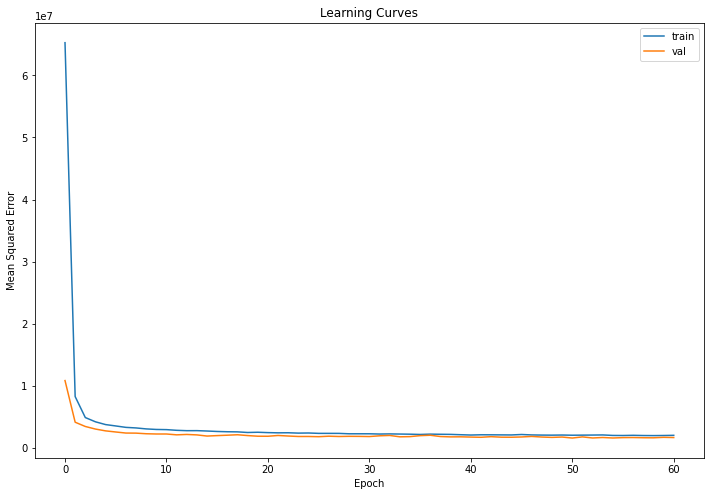

Train RMSE: 1236.111, Train MAPE: 6.787 

Val RMSE: 1315.463, Val MAPE: 6.968 

Test RMSE: 1281.399, Test MAPE: 7.079 

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 512)               27136     
_________________________________________________________________
batch_normalization_18 (Batc (None, 512)               2048      
_________________________________________________________________
dense_55 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_18 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 257       
Total params: 160,769
Trainable params: 159,745
Non-trainable params: 1,024
_______________________________________________________

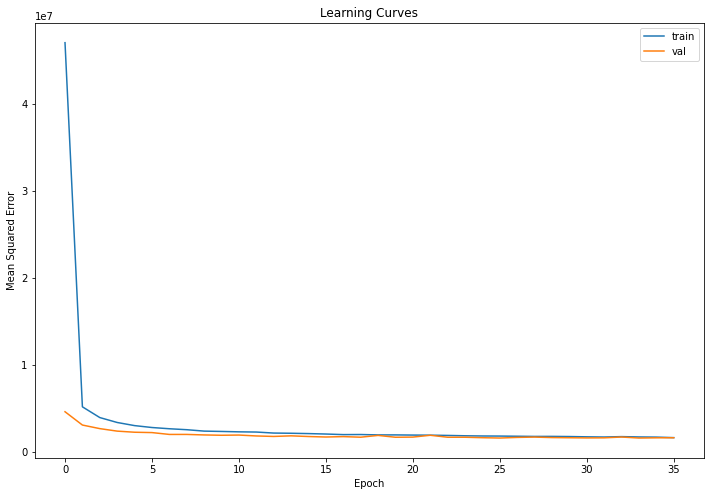

Train RMSE: 1177.575, Train MAPE: 6.417 

Val RMSE: 1236.050, Val MAPE: 6.642 

Test RMSE: 1266.754, Test MAPE: 6.748 

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 8)                 424       
_________________________________________________________________
dropout_19 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_58 (Dense)             (None, 16)                144       
_________________________________________________________________
dropout_20 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 17        
Total params: 585
Trainable params: 585
Non-trainable params: 0
_________________________________________________________________
N

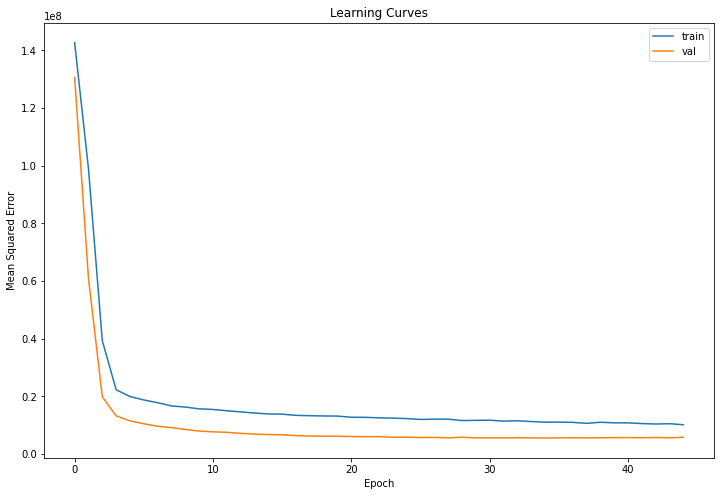

Train RMSE: 2367.063, Train MAPE: 13.088 

Val RMSE: 2293.001, Val MAPE: 12.866 

Test RMSE: 2320.908, Test MAPE: 13.086 

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 16)                848       
_________________________________________________________________
dropout_21 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_61 (Dense)             (None, 32)                544       
_________________________________________________________________
dropout_22 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 33        
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
____________________________________________________________

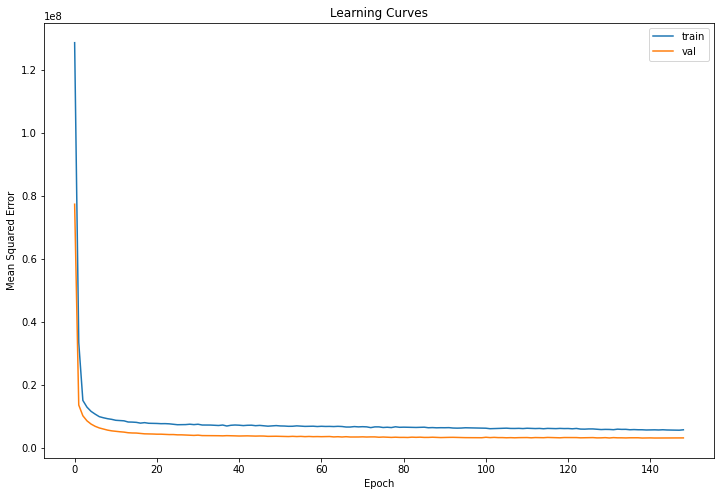

Train RMSE: 1784.813, Train MAPE: 10.237 

Val RMSE: 1745.597, Val MAPE: 10.094 

Test RMSE: 1761.129, Test MAPE: 10.243 

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 32)                1696      
_________________________________________________________________
dropout_23 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_64 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_24 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 65        
Total params: 3,873
Trainable params: 3,873
Non-trainable params: 0
____________________________________________________________

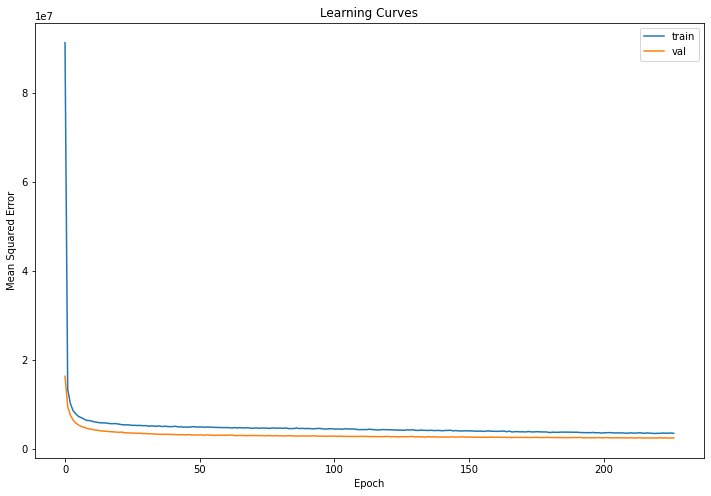

Train RMSE: 1507.747, Train MAPE: 8.694 

Val RMSE: 1488.986, Val MAPE: 8.595 

Test RMSE: 1496.080, Test MAPE: 8.825 

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 64)                3392      
_________________________________________________________________
dropout_25 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_67 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_26 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_68 (Dense)             (None, 1)                 129       
Total params: 11,841
Trainable params: 11,841
Non-trainable params: 0
_____________________________________________________________

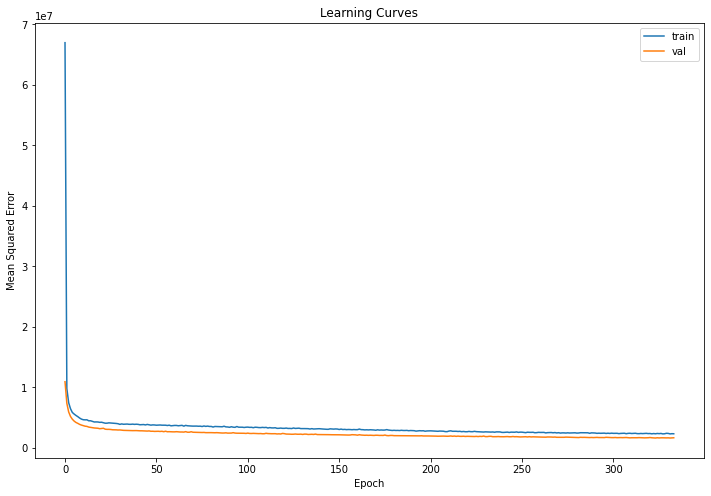

Train RMSE: 1231.148, Train MAPE: 7.038 

Val RMSE: 1251.649, Val MAPE: 7.100 

Test RMSE: 1251.603, Test MAPE: 7.260 

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 128)               6784      
_________________________________________________________________
dropout_27 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_28 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 1)                 257       
Total params: 40,065
Trainable params: 40,065
Non-trainable params: 0
_____________________________________________________________

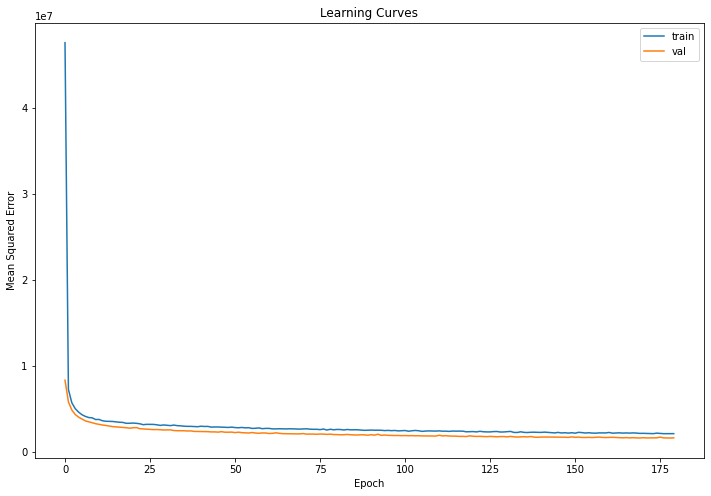

Train RMSE: 1192.665, Train MAPE: 6.895 

Val RMSE: 1215.003, Val MAPE: 7.062 

Test RMSE: 1224.304, Test MAPE: 7.174 

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 256)               13568     
_________________________________________________________________
dropout_29 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_30 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 513       
Total params: 145,665
Trainable params: 145,665
Non-trainable params: 0
___________________________________________________________

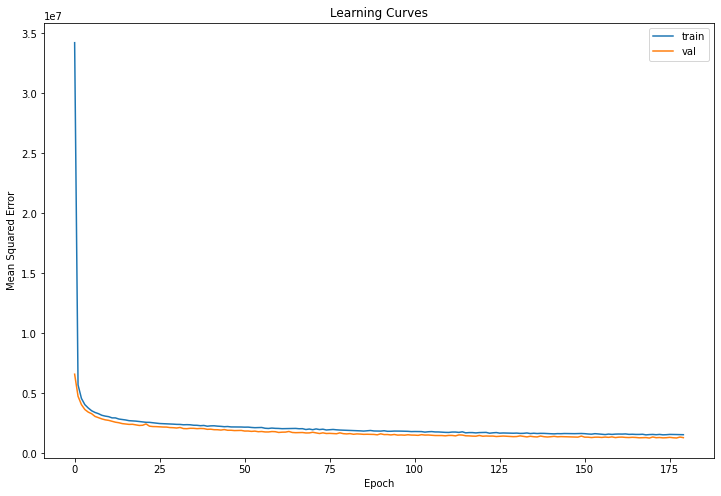

Train RMSE: 1052.208, Train MAPE: 6.300 

Val RMSE: 1097.484, Val MAPE: 6.615 

Test RMSE: 1118.537, Test MAPE: 6.729 

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 8)                 424       
_________________________________________________________________
dropout_31 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_76 (Dense)             (None, 8)                 72        
_________________________________________________________________
dropout_32 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_77 (Dense)             (None, 1)                 9         
Total params: 505
Trainable params: 505
Non-trainable params: 0
_________________________________________________________________
N

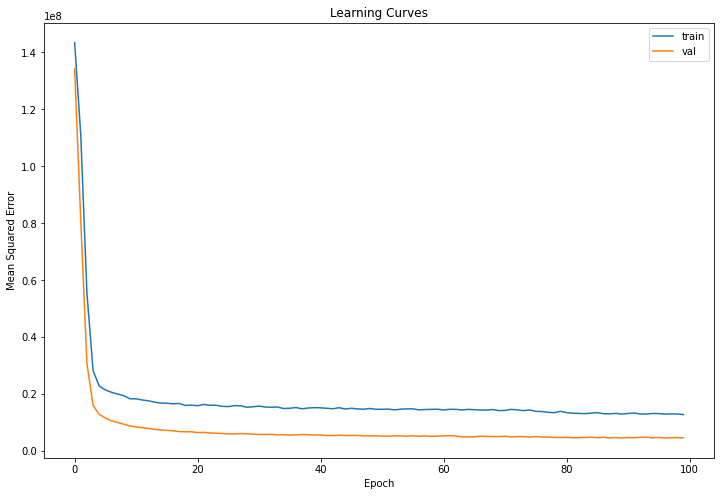

Train RMSE: 2110.566, Train MAPE: 11.943 

Val RMSE: 2042.478, Val MAPE: 11.695 

Test RMSE: 2067.243, Test MAPE: 11.919 

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 16)                848       
_________________________________________________________________
dropout_33 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_79 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_34 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_80 (Dense)             (None, 1)                 17        
Total params: 1,137
Trainable params: 1,137
Non-trainable params: 0
____________________________________________________________

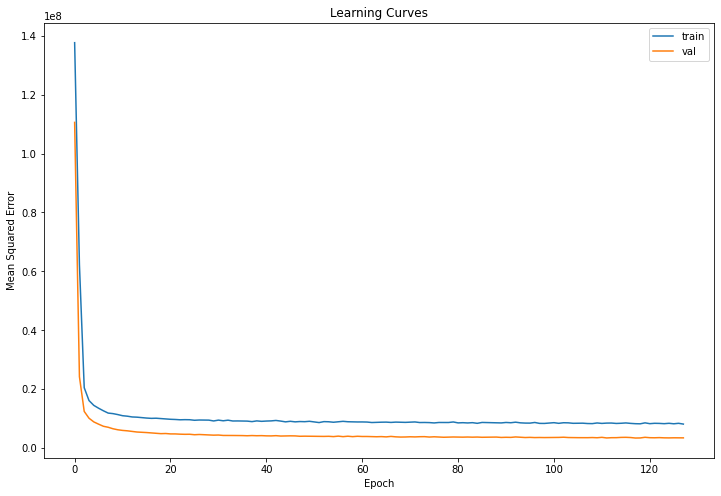

Train RMSE: 1837.818, Train MAPE: 10.585 

Val RMSE: 1798.171, Val MAPE: 10.438 

Test RMSE: 1805.754, Test MAPE: 10.508 

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 32)                1696      
_________________________________________________________________
dropout_35 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_82 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_36 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 33        
Total params: 2,785
Trainable params: 2,785
Non-trainable params: 0
____________________________________________________________

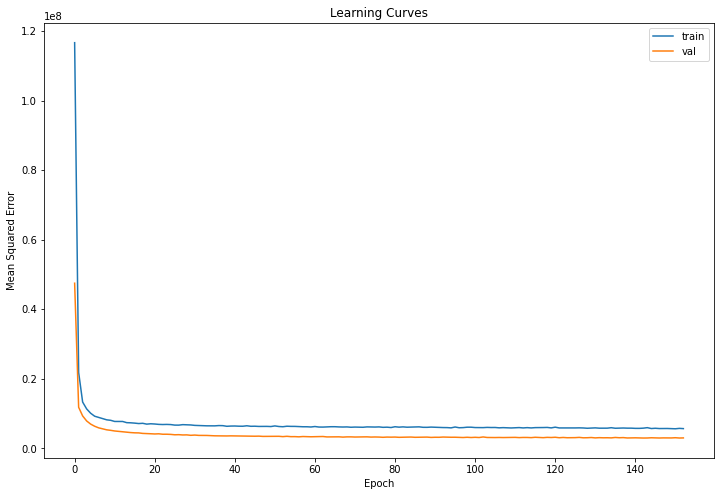

Train RMSE: 1697.337, Train MAPE: 9.596 

Val RMSE: 1673.648, Val MAPE: 9.569 

Test RMSE: 1676.596, Test MAPE: 9.656 

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 64)                3392      
_________________________________________________________________
dropout_37 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_85 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_38 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_86 (Dense)             (None, 1)                 65        
Total params: 7,617
Trainable params: 7,617
Non-trainable params: 0
_______________________________________________________________

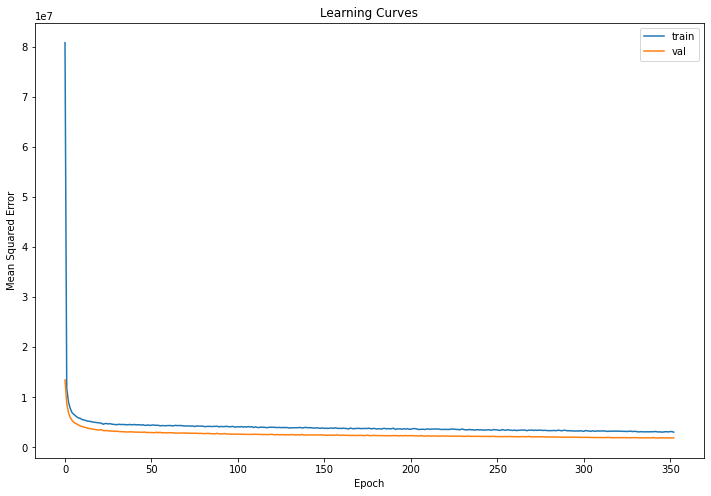

Train RMSE: 1330.953, Train MAPE: 7.858 

Val RMSE: 1341.833, Val MAPE: 7.884 

Test RMSE: 1345.014, Test MAPE: 7.997 

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_87 (Dense)             (None, 128)               6784      
_________________________________________________________________
dropout_39 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_88 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_40 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_89 (Dense)             (None, 1)                 129       
Total params: 23,425
Trainable params: 23,425
Non-trainable params: 0
_____________________________________________________________

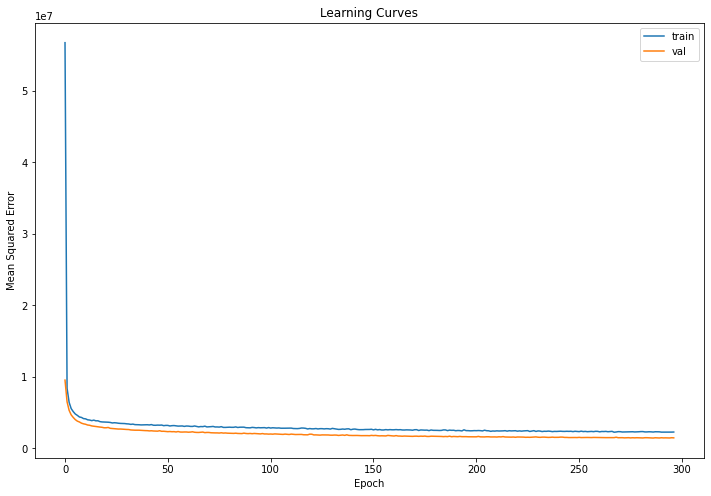

Train RMSE: 1156.258, Train MAPE: 6.792 

Val RMSE: 1166.347, Val MAPE: 6.930 

Test RMSE: 1182.862, Test MAPE: 7.076 

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 256)               13568     
_________________________________________________________________
dropout_41 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_91 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_42 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_92 (Dense)             (None, 1)                 257       
Total params: 79,617
Trainable params: 79,617
Non-trainable params: 0
_____________________________________________________________

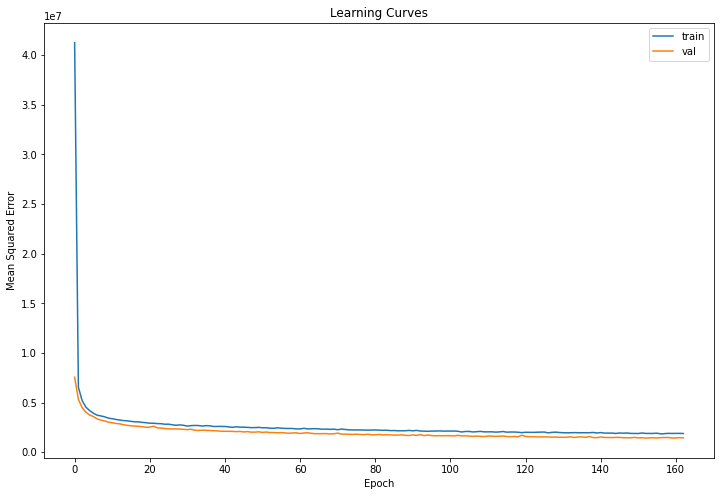

Train RMSE: 1122.104, Train MAPE: 6.416 

Val RMSE: 1152.171, Val MAPE: 6.648 

Test RMSE: 1158.793, Test MAPE: 6.756 

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_93 (Dense)             (None, 512)               27136     
_________________________________________________________________
dropout_43 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_94 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_44 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_95 (Dense)             (None, 1)                 513       
Total params: 290,305
Trainable params: 290,305
Non-trainable params: 0
___________________________________________________________

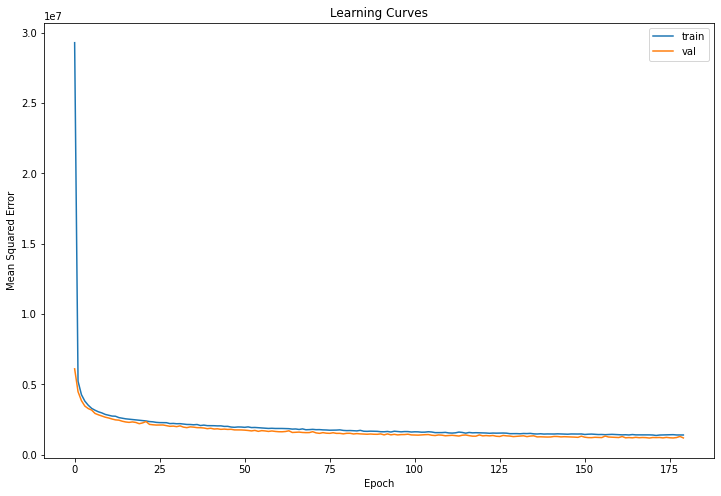

Train RMSE: 999.003, Train MAPE: 5.915 

Val RMSE: 1042.362, Val MAPE: 6.249 

Test RMSE: 1064.188, Test MAPE: 6.369 

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_96 (Dense)             (None, 16)                848       
_________________________________________________________________
dropout_45 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_97 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_46 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_98 (Dense)             (None, 1)                 9         
Total params: 993
Trainable params: 993
Non-trainable params: 0
_________________________________________________________________
No

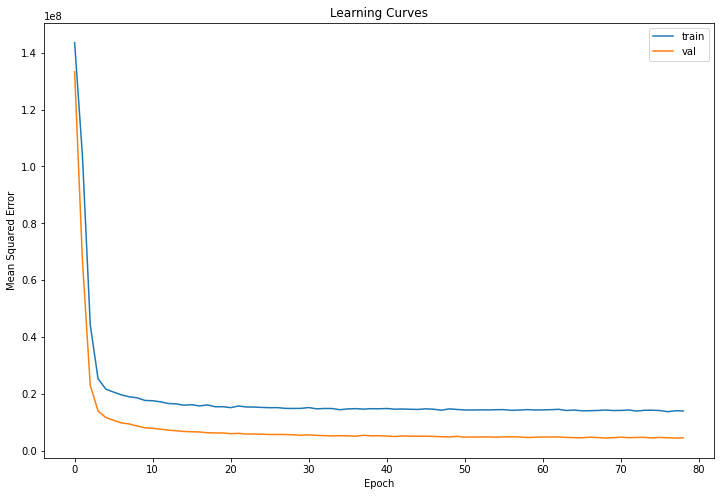

Train RMSE: 2101.642, Train MAPE: 11.793 

Val RMSE: 2037.495, Val MAPE: 11.601 

Test RMSE: 2060.308, Test MAPE: 11.785 

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_99 (Dense)             (None, 32)                1696      
_________________________________________________________________
dropout_47 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_100 (Dense)            (None, 16)                528       
_________________________________________________________________
dropout_48 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_101 (Dense)            (None, 1)                 17        
Total params: 2,241
Trainable params: 2,241
Non-trainable params: 0
____________________________________________________________

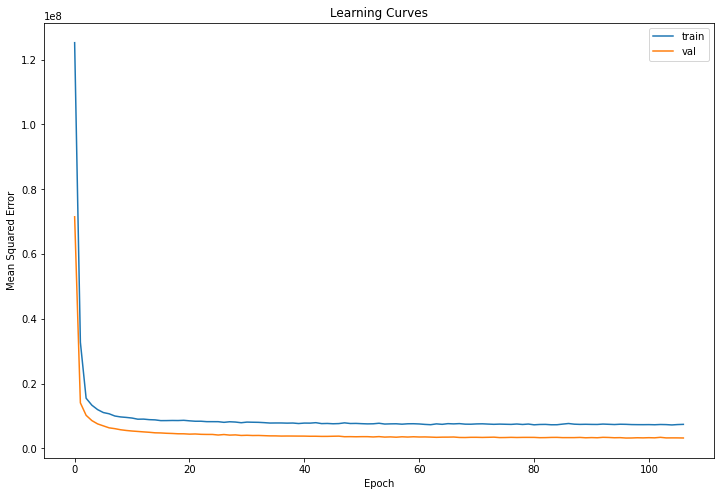

Train RMSE: 1778.449, Train MAPE: 10.258 

Val RMSE: 1734.944, Val MAPE: 10.104 

Test RMSE: 1753.792, Test MAPE: 10.253 

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_102 (Dense)            (None, 64)                3392      
_________________________________________________________________
dropout_49 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_103 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_50 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_104 (Dense)            (None, 1)                 33        
Total params: 5,505
Trainable params: 5,505
Non-trainable params: 0
____________________________________________________________

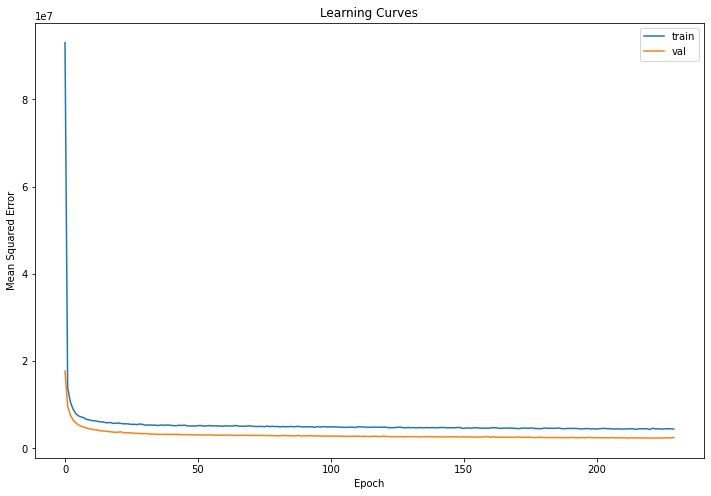

Train RMSE: 1527.693, Train MAPE: 8.469 

Val RMSE: 1515.742, Val MAPE: 8.494 

Test RMSE: 1515.253, Test MAPE: 8.611 

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_105 (Dense)            (None, 128)               6784      
_________________________________________________________________
dropout_51 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_106 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_52 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_107 (Dense)            (None, 1)                 65        
Total params: 15,105
Trainable params: 15,105
Non-trainable params: 0
_____________________________________________________________

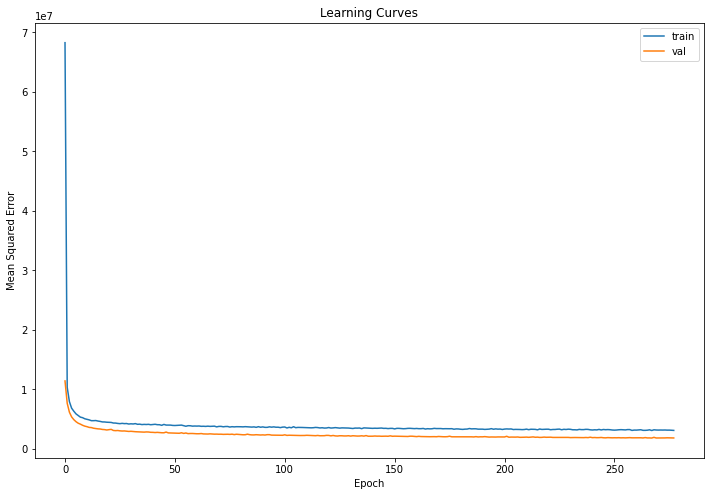

Train RMSE: 1302.553, Train MAPE: 7.492 

Val RMSE: 1317.704, Val MAPE: 7.597 

Test RMSE: 1324.990, Test MAPE: 7.731 

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_108 (Dense)            (None, 256)               13568     
_________________________________________________________________
dropout_53 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_109 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_54 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_110 (Dense)            (None, 1)                 129       
Total params: 46,593
Trainable params: 46,593
Non-trainable params: 0
_____________________________________________________________

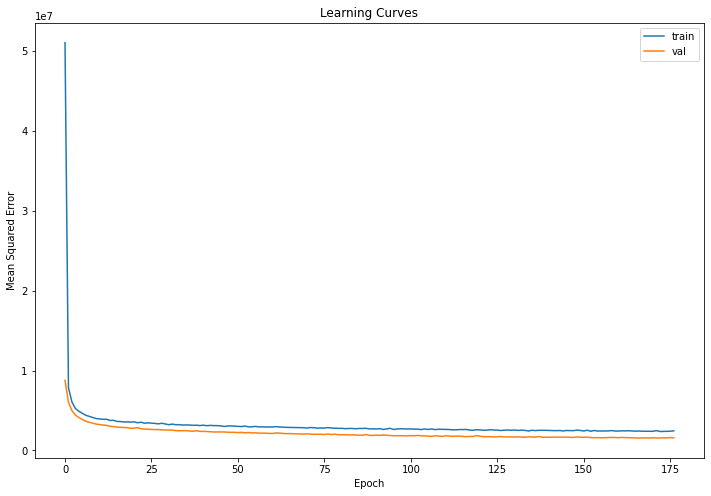

Train RMSE: 1197.266, Train MAPE: 7.163 

Val RMSE: 1222.577, Val MAPE: 7.323 

Test RMSE: 1233.873, Test MAPE: 7.453 

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_111 (Dense)            (None, 512)               27136     
_________________________________________________________________
dropout_55 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_112 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_56 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_113 (Dense)            (None, 1)                 257       
Total params: 158,721
Trainable params: 158,721
Non-trainable params: 0
___________________________________________________________

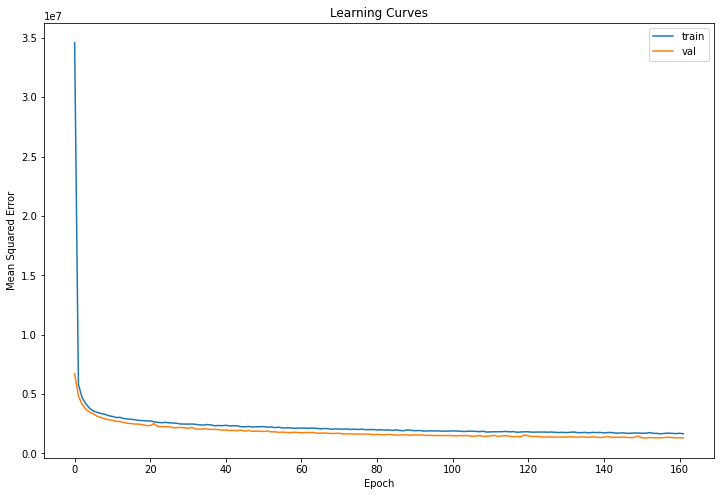

Train RMSE: 1062.349, Train MAPE: 6.175 

Val RMSE: 1104.322, Val MAPE: 6.441 

Test RMSE: 1113.851, Test MAPE: 6.560 

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_114 (Dense)            (None, 8)                 424       
_________________________________________________________________
batch_normalization_19 (Batc (None, 8)                 32        
_________________________________________________________________
dense_115 (Dense)            (None, 16)                144       
_________________________________________________________________
dropout_57 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_116 (Dense)            (None, 1)                 17        
Total params: 617
Trainable params: 601
Non-trainable params: 16
_________________________________________________________________


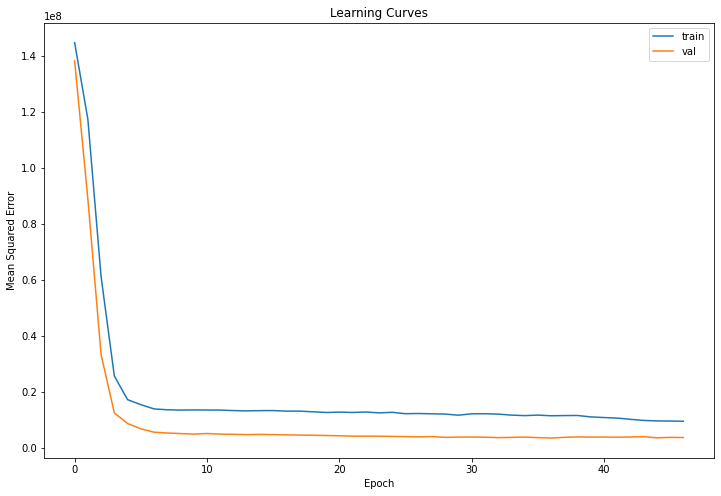

Train RMSE: 1863.857, Train MAPE: 11.622 

Val RMSE: 1836.460, Val MAPE: 11.604 

Test RMSE: 1831.843, Test MAPE: 11.641 

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_117 (Dense)            (None, 16)                848       
_________________________________________________________________
batch_normalization_20 (Batc (None, 16)                64        
_________________________________________________________________
dense_118 (Dense)            (None, 32)                544       
_________________________________________________________________
dropout_58 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_119 (Dense)            (None, 1)                 33        
Total params: 1,489
Trainable params: 1,457
Non-trainable params: 32
___________________________________________________________

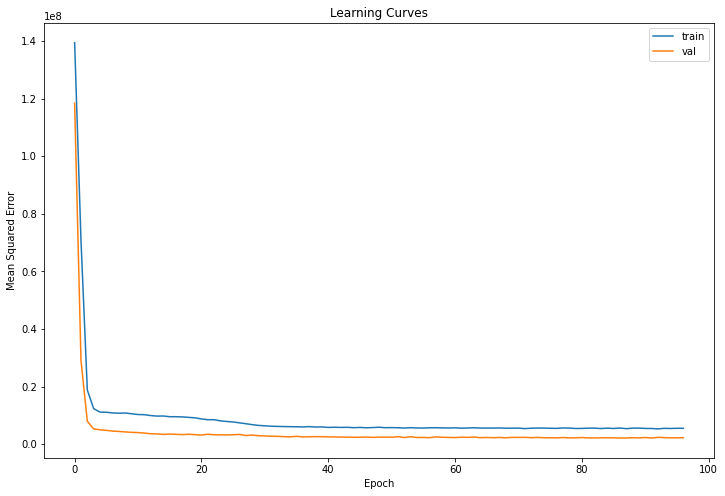

Train RMSE: 1450.846, Train MAPE: 8.937 

Val RMSE: 1461.051, Val MAPE: 8.886 

Test RMSE: 1459.985, Test MAPE: 8.995 

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_120 (Dense)            (None, 32)                1696      
_________________________________________________________________
batch_normalization_21 (Batc (None, 32)                128       
_________________________________________________________________
dense_121 (Dense)            (None, 64)                2112      
_________________________________________________________________
dropout_59 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_122 (Dense)            (None, 1)                 65        
Total params: 4,001
Trainable params: 3,937
Non-trainable params: 64
______________________________________________________________

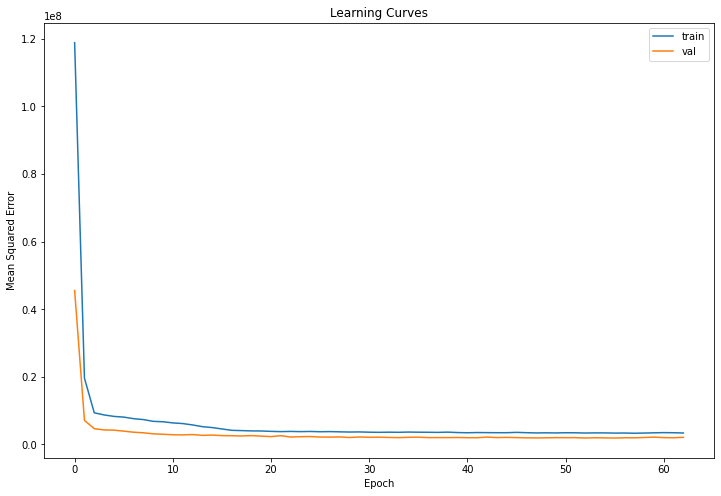

Train RMSE: 1403.530, Train MAPE: 7.996 

Val RMSE: 1429.723, Val MAPE: 8.110 

Test RMSE: 1407.535, Test MAPE: 8.212 

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_123 (Dense)            (None, 64)                3392      
_________________________________________________________________
batch_normalization_22 (Batc (None, 64)                256       
_________________________________________________________________
dense_124 (Dense)            (None, 128)               8320      
_________________________________________________________________
dropout_60 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_125 (Dense)            (None, 1)                 129       
Total params: 12,097
Trainable params: 11,969
Non-trainable params: 128
___________________________________________________________

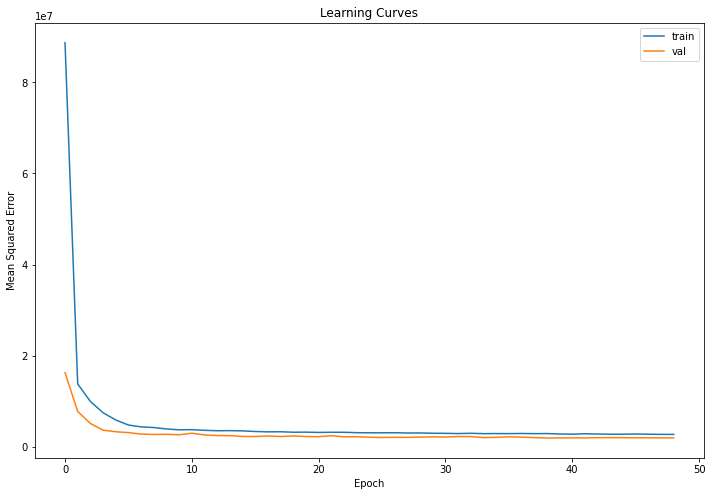

Train RMSE: 1348.253, Train MAPE: 7.582 

Val RMSE: 1398.893, Val MAPE: 7.706 

Test RMSE: 1363.678, Test MAPE: 7.769 

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_126 (Dense)            (None, 128)               6784      
_________________________________________________________________
batch_normalization_23 (Batc (None, 128)               512       
_________________________________________________________________
dense_127 (Dense)            (None, 256)               33024     
_________________________________________________________________
dropout_61 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_128 (Dense)            (None, 1)                 257       
Total params: 40,577
Trainable params: 40,321
Non-trainable params: 256
___________________________________________________________

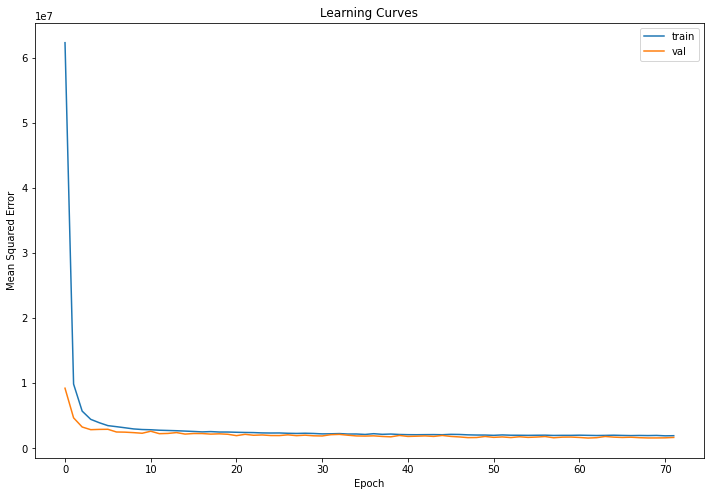

Train RMSE: 1259.170, Train MAPE: 6.903 

Val RMSE: 1318.873, Val MAPE: 7.098 

Test RMSE: 1292.300, Test MAPE: 7.181 

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_129 (Dense)            (None, 256)               13568     
_________________________________________________________________
batch_normalization_24 (Batc (None, 256)               1024      
_________________________________________________________________
dense_130 (Dense)            (None, 512)               131584    
_________________________________________________________________
dropout_62 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_131 (Dense)            (None, 1)                 513       
Total params: 146,689
Trainable params: 146,177
Non-trainable params: 512
_________________________________________________________

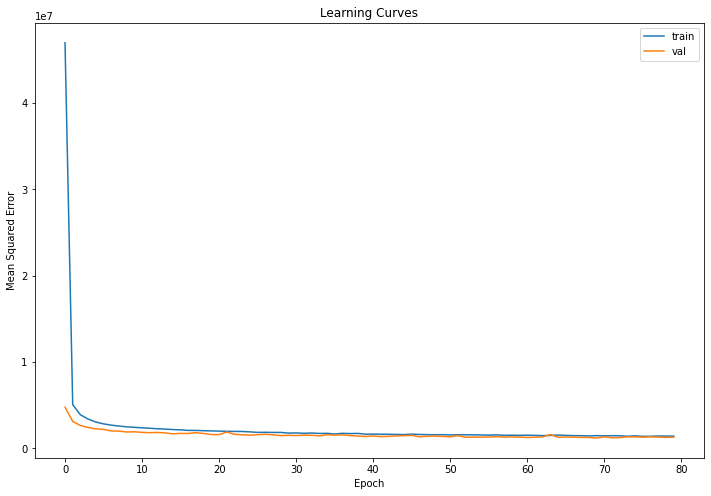

Train RMSE: 1038.882, Train MAPE: 5.936 

Val RMSE: 1079.101, Val MAPE: 6.379 

Test RMSE: 1106.472, Test MAPE: 6.322 

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_132 (Dense)            (None, 8)                 424       
_________________________________________________________________
batch_normalization_25 (Batc (None, 8)                 32        
_________________________________________________________________
dense_133 (Dense)            (None, 8)                 72        
_________________________________________________________________
dropout_63 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_134 (Dense)            (None, 1)                 9         
Total params: 537
Trainable params: 521
Non-trainable params: 16
_________________________________________________________________


Train RMSE: 2527.603, Train MAPE: 15.404 

Val RMSE: 2481.819, Val MAPE: 15.345 

Test RMSE: 2514.165, Test MAPE: 15.544 

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_135 (Dense)            (None, 16)                848       
_________________________________________________________________
batch_normalization_26 (Batc (None, 16)                64        
_________________________________________________________________
dense_136 (Dense)            (None, 16)                272       
_________________________________________________________________
dropout_64 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_137 (Dense)            (None, 1)                 17        
Total params: 1,201
Trainable params: 1,169
Non-trainable params: 32
___________________________________________________________

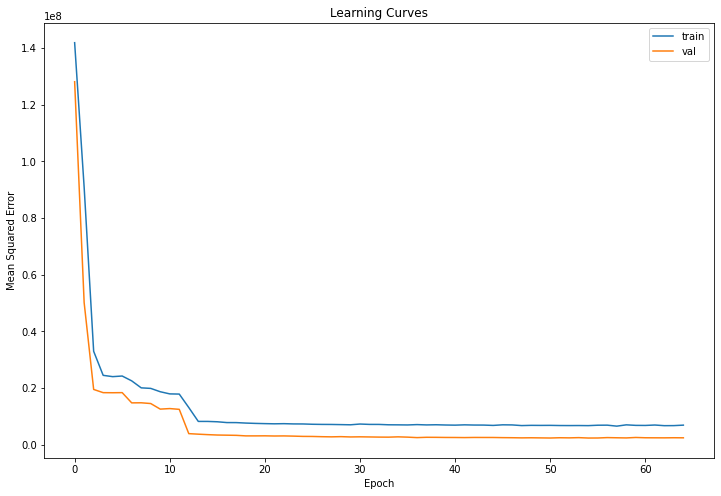

Train RMSE: 1529.540, Train MAPE: 8.470 

Val RMSE: 1511.077, Val MAPE: 8.394 

Test RMSE: 1522.481, Test MAPE: 8.646 

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_138 (Dense)            (None, 32)                1696      
_________________________________________________________________
batch_normalization_27 (Batc (None, 32)                128       
_________________________________________________________________
dense_139 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_65 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_140 (Dense)            (None, 1)                 33        
Total params: 2,913
Trainable params: 2,849
Non-trainable params: 64
______________________________________________________________

Train RMSE: 1431.719, Train MAPE: 8.266 

Val RMSE: 1433.706, Val MAPE: 8.313 

Test RMSE: 1414.360, Test MAPE: 8.393 

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_141 (Dense)            (None, 64)                3392      
_________________________________________________________________
batch_normalization_28 (Batc (None, 64)                256       
_________________________________________________________________
dense_142 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_66 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_143 (Dense)            (None, 1)                 65        
Total params: 7,873
Trainable params: 7,745
Non-trainable params: 128
_____________________________________________________________

Train RMSE: 1383.154, Train MAPE: 7.655 

Val RMSE: 1410.626, Val MAPE: 7.766 

Test RMSE: 1365.611, Test MAPE: 7.780 

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_144 (Dense)            (None, 128)               6784      
_________________________________________________________________
batch_normalization_29 (Batc (None, 128)               512       
_________________________________________________________________
dense_145 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_67 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_146 (Dense)            (None, 1)                 129       
Total params: 23,937
Trainable params: 23,681
Non-trainable params: 256
___________________________________________________________

Train RMSE: 1217.207, Train MAPE: 6.702 

Val RMSE: 1255.643, Val MAPE: 6.894 

Test RMSE: 1230.707, Test MAPE: 7.009 

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_147 (Dense)            (None, 256)               13568     
_________________________________________________________________
batch_normalization_30 (Batc (None, 256)               1024      
_________________________________________________________________
dense_148 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_68 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_149 (Dense)            (None, 1)                 257       
Total params: 80,641
Trainable params: 80,129
Non-trainable params: 512
___________________________________________________________

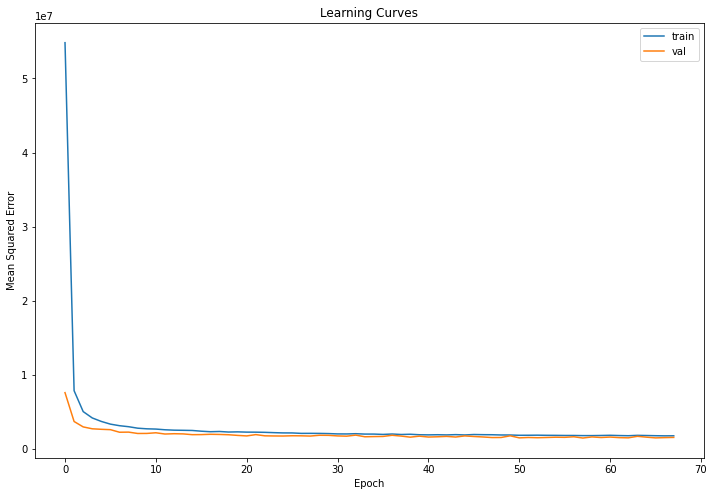

Train RMSE: 1184.587, Train MAPE: 6.547 

Val RMSE: 1219.644, Val MAPE: 6.749 

Test RMSE: 1205.533, Test MAPE: 6.834 

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_150 (Dense)            (None, 512)               27136     
_________________________________________________________________
batch_normalization_31 (Batc (None, 512)               2048      
_________________________________________________________________
dense_151 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_69 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_152 (Dense)            (None, 1)                 513       
Total params: 292,353
Trainable params: 291,329
Non-trainable params: 1,024
_______________________________________________________

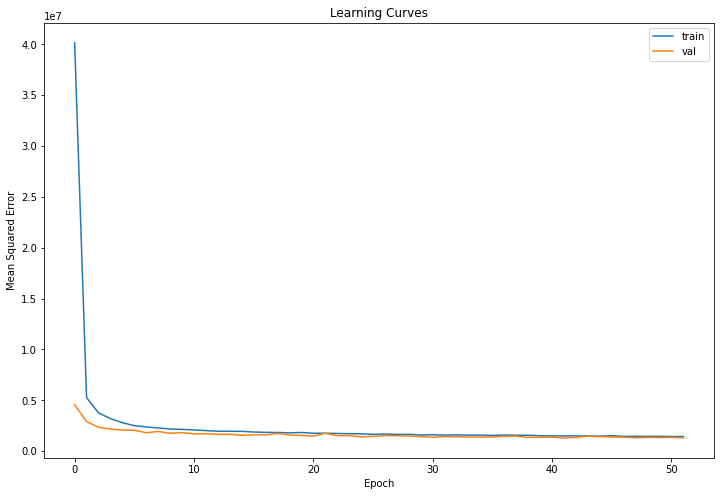

Train RMSE: 1075.688, Train MAPE: 6.037 

Val RMSE: 1121.268, Val MAPE: 6.327 

Test RMSE: 1122.711, Test MAPE: 6.456 

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_153 (Dense)            (None, 16)                848       
_________________________________________________________________
batch_normalization_32 (Batc (None, 16)                64        
_________________________________________________________________
dense_154 (Dense)            (None, 8)                 136       
_________________________________________________________________
dropout_70 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_155 (Dense)            (None, 1)                 9         
Total params: 1,057
Trainable params: 1,025
Non-trainable params: 32
______________________________________________________________

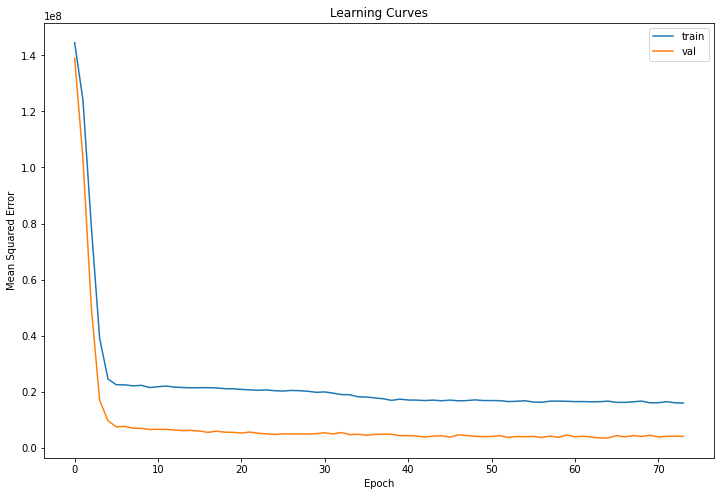

Train RMSE: 1967.849, Train MAPE: 11.312 

Val RMSE: 1949.354, Val MAPE: 11.413 

Test RMSE: 1961.970, Test MAPE: 11.388 

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_156 (Dense)            (None, 32)                1696      
_________________________________________________________________
batch_normalization_33 (Batc (None, 32)                128       
_________________________________________________________________
dense_157 (Dense)            (None, 16)                528       
_________________________________________________________________
dropout_71 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_158 (Dense)            (None, 1)                 17        
Total params: 2,369
Trainable params: 2,305
Non-trainable params: 64
___________________________________________________________

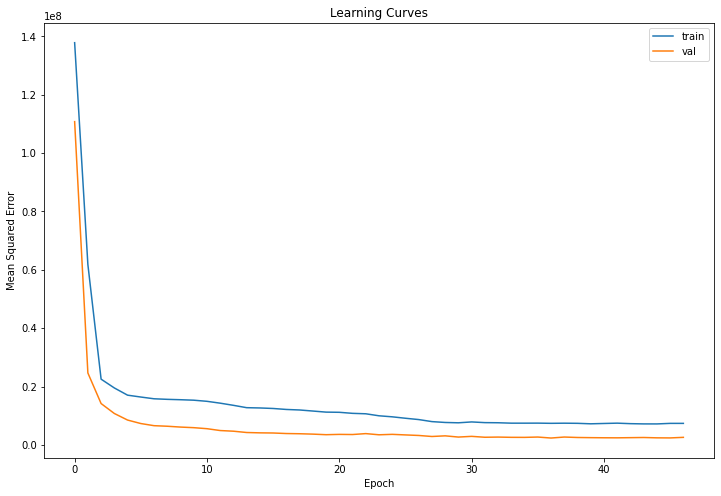

Train RMSE: 1565.370, Train MAPE: 8.775 

Val RMSE: 1545.368, Val MAPE: 8.783 

Test RMSE: 1563.101, Test MAPE: 8.877 

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_159 (Dense)            (None, 64)                3392      
_________________________________________________________________
batch_normalization_34 (Batc (None, 64)                256       
_________________________________________________________________
dense_160 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_72 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_161 (Dense)            (None, 1)                 33        
Total params: 5,761
Trainable params: 5,633
Non-trainable params: 128
_____________________________________________________________

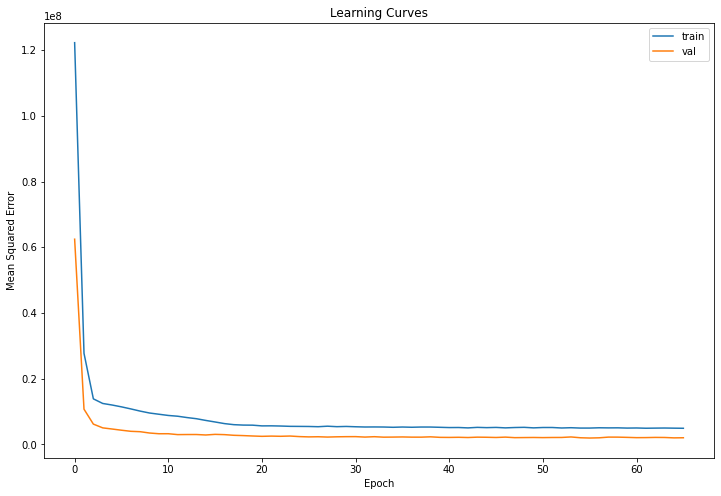

Train RMSE: 1364.402, Train MAPE: 7.976 

Val RMSE: 1380.697, Val MAPE: 8.061 

Test RMSE: 1372.225, Test MAPE: 8.101 

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_162 (Dense)            (None, 128)               6784      
_________________________________________________________________
batch_normalization_35 (Batc (None, 128)               512       
_________________________________________________________________
dense_163 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_73 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_164 (Dense)            (None, 1)                 65        
Total params: 15,617
Trainable params: 15,361
Non-trainable params: 256
___________________________________________________________

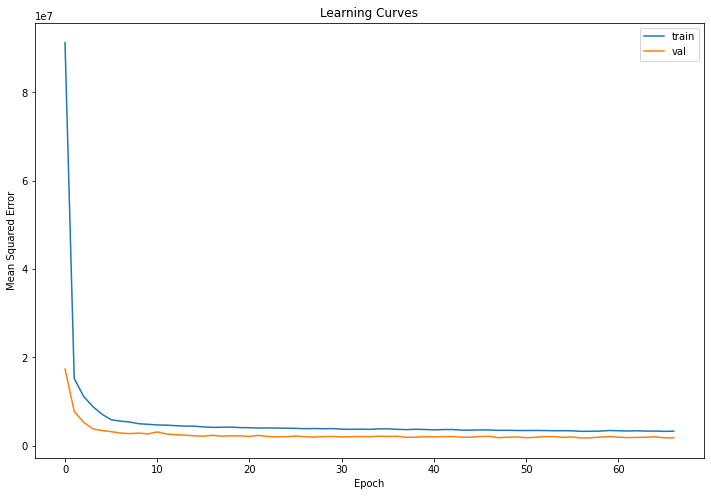

Train RMSE: 1295.365, Train MAPE: 7.280 

Val RMSE: 1364.046, Val MAPE: 7.410 

Test RMSE: 1374.191, Test MAPE: 7.560 

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_165 (Dense)            (None, 256)               13568     
_________________________________________________________________
batch_normalization_36 (Batc (None, 256)               1024      
_________________________________________________________________
dense_166 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_74 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_167 (Dense)            (None, 1)                 129       
Total params: 47,617
Trainable params: 47,105
Non-trainable params: 512
___________________________________________________________

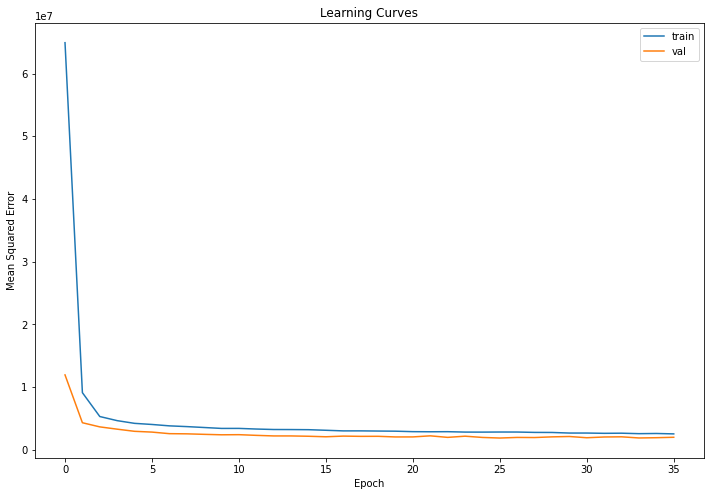

Train RMSE: 1375.269, Train MAPE: 7.399 

Val RMSE: 1425.546, Val MAPE: 7.484 

Test RMSE: 1385.216, Test MAPE: 7.569 

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_168 (Dense)            (None, 512)               27136     
_________________________________________________________________
batch_normalization_37 (Batc (None, 512)               2048      
_________________________________________________________________
dense_169 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_75 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_170 (Dense)            (None, 1)                 257       
Total params: 160,769
Trainable params: 159,745
Non-trainable params: 1,024
_______________________________________________________

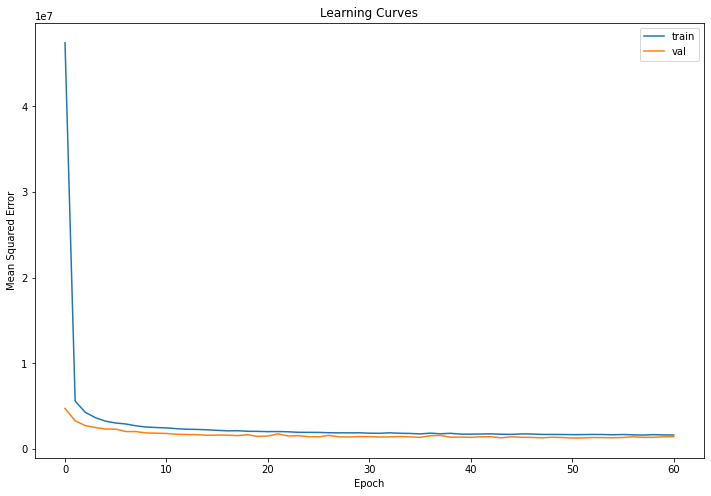

Train RMSE: 1172.613, Train MAPE: 6.456 

Val RMSE: 1211.835, Val MAPE: 6.741 

Test RMSE: 1285.141, Test MAPE: 6.814 

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_171 (Dense)            (None, 8)                 424       
_________________________________________________________________
dropout_76 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_172 (Dense)            (None, 16)                144       
_________________________________________________________________
dropout_77 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_173 (Dense)            (None, 1)                 17        
Total params: 585
Trainable params: 585
Non-trainable params: 0
_________________________________________________________________
N

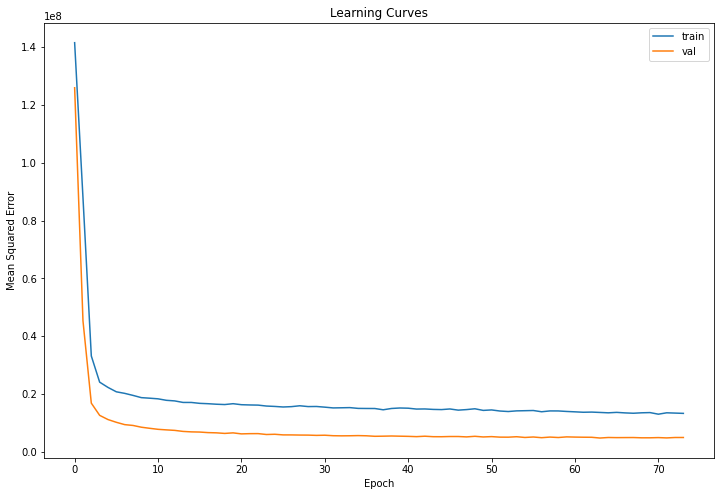

Train RMSE: 2184.615, Train MAPE: 12.203 

Val RMSE: 2113.215, Val MAPE: 11.963 

Test RMSE: 2140.582, Test MAPE: 12.170 

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_174 (Dense)            (None, 16)                848       
_________________________________________________________________
dropout_78 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_175 (Dense)            (None, 32)                544       
_________________________________________________________________
dropout_79 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_176 (Dense)            (None, 1)                 33        
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
____________________________________________________________

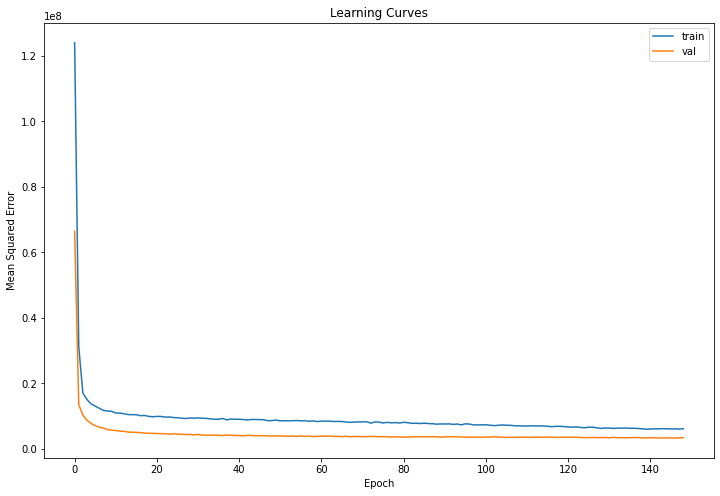

Train RMSE: 1843.703, Train MAPE: 10.622 

Val RMSE: 1800.914, Val MAPE: 10.473 

Test RMSE: 1813.487, Test MAPE: 10.640 

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_177 (Dense)            (None, 32)                1696      
_________________________________________________________________
dropout_80 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_178 (Dense)            (None, 64)                2112      
_________________________________________________________________
dropout_81 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_179 (Dense)            (None, 1)                 65        
Total params: 3,873
Trainable params: 3,873
Non-trainable params: 0
____________________________________________________________

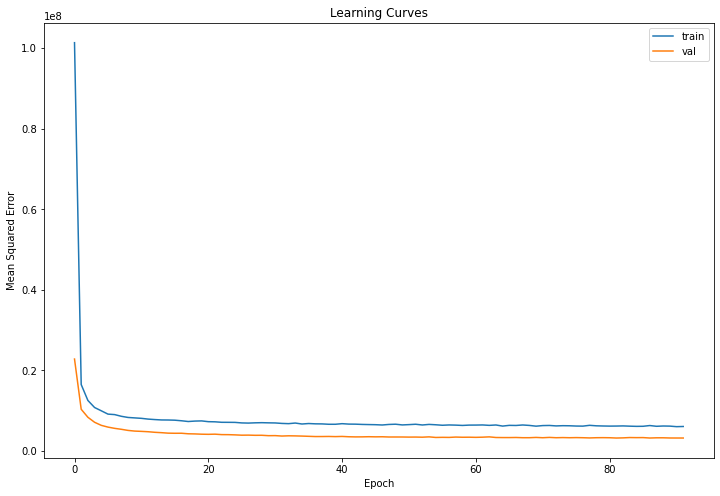

Train RMSE: 1773.658, Train MAPE: 10.316 

Val RMSE: 1732.364, Val MAPE: 10.151 

Test RMSE: 1746.744, Test MAPE: 10.317 

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_180 (Dense)            (None, 64)                3392      
_________________________________________________________________
dropout_82 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_181 (Dense)            (None, 128)               8320      
_________________________________________________________________
dropout_83 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_182 (Dense)            (None, 1)                 129       
Total params: 11,841
Trainable params: 11,841
Non-trainable params: 0
__________________________________________________________

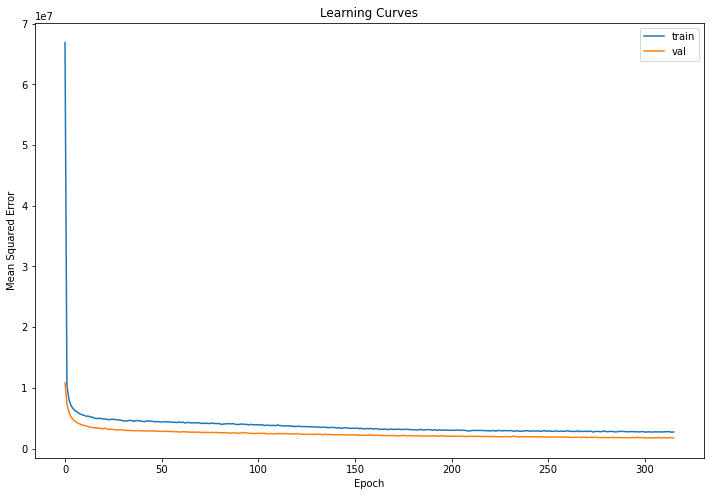

Train RMSE: 1287.947, Train MAPE: 7.752 

Val RMSE: 1320.213, Val MAPE: 7.815 

Test RMSE: 1316.789, Test MAPE: 7.933 

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_183 (Dense)            (None, 128)               6784      
_________________________________________________________________
dropout_84 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_184 (Dense)            (None, 256)               33024     
_________________________________________________________________
dropout_85 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_185 (Dense)            (None, 1)                 257       
Total params: 40,065
Trainable params: 40,065
Non-trainable params: 0
_____________________________________________________________

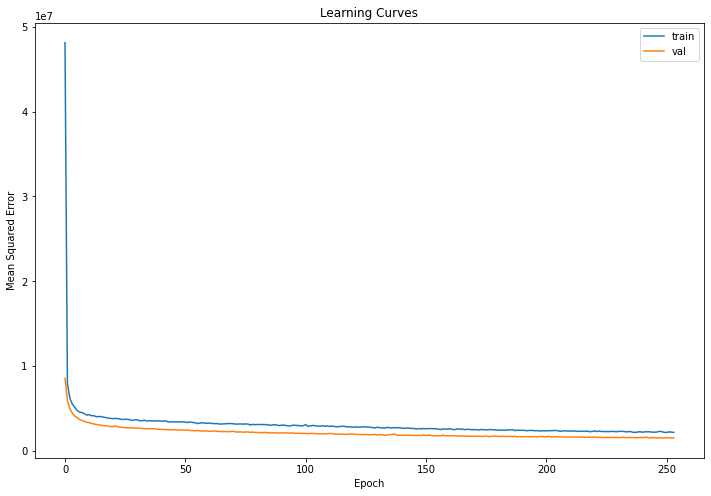

Train RMSE: 1181.833, Train MAPE: 7.070 

Val RMSE: 1217.196, Val MAPE: 7.219 

Test RMSE: 1211.021, Test MAPE: 7.312 

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_186 (Dense)            (None, 256)               13568     
_________________________________________________________________
dropout_86 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_187 (Dense)            (None, 512)               131584    
_________________________________________________________________
dropout_87 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_188 (Dense)            (None, 1)                 513       
Total params: 145,665
Trainable params: 145,665
Non-trainable params: 0
___________________________________________________________

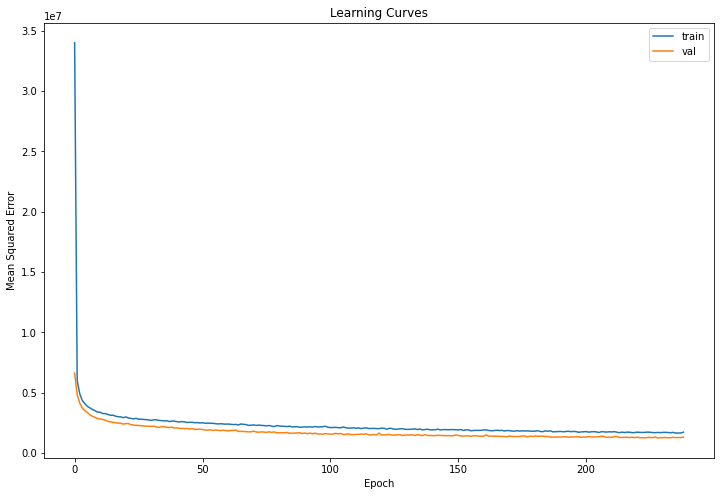

Train RMSE: 1072.285, Train MAPE: 6.141 

Val RMSE: 1105.118, Val MAPE: 6.378 

Test RMSE: 1118.646, Test MAPE: 6.471 

Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_189 (Dense)            (None, 8)                 424       
_________________________________________________________________
dropout_88 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_190 (Dense)            (None, 8)                 72        
_________________________________________________________________
dropout_89 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_191 (Dense)            (None, 1)                 9         
Total params: 505
Trainable params: 505
Non-trainable params: 0
_________________________________________________________________
N

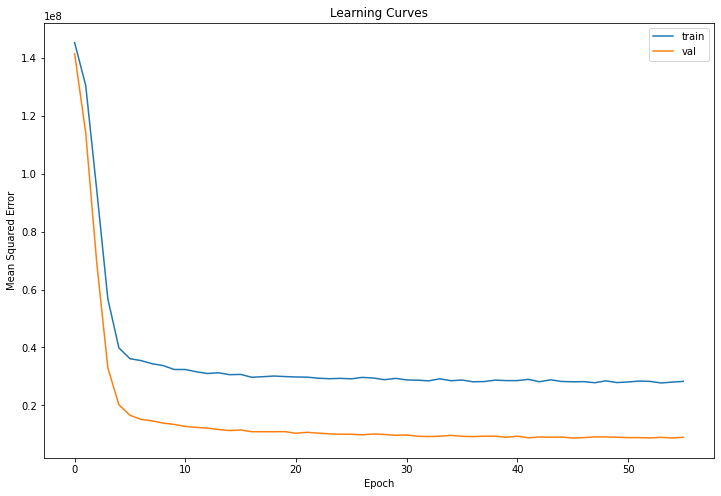

Train RMSE: 2953.425, Train MAPE: 17.089 

Val RMSE: 2881.562, Val MAPE: 16.884 

Test RMSE: 2913.126, Test MAPE: 17.173 

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_192 (Dense)            (None, 16)                848       
_________________________________________________________________
dropout_90 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_193 (Dense)            (None, 16)                272       
_________________________________________________________________
dropout_91 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_194 (Dense)            (None, 1)                 17        
Total params: 1,137
Trainable params: 1,137
Non-trainable params: 0
____________________________________________________________

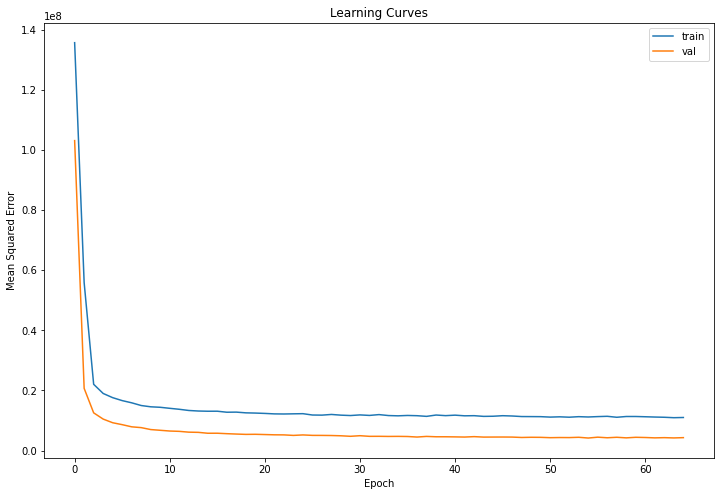

Train RMSE: 2041.287, Train MAPE: 11.512 

Val RMSE: 1975.694, Val MAPE: 11.305 

Test RMSE: 1996.350, Test MAPE: 11.484 

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_195 (Dense)            (None, 32)                1696      
_________________________________________________________________
dropout_92 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_196 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_93 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_197 (Dense)            (None, 1)                 33        
Total params: 2,785
Trainable params: 2,785
Non-trainable params: 0
____________________________________________________________

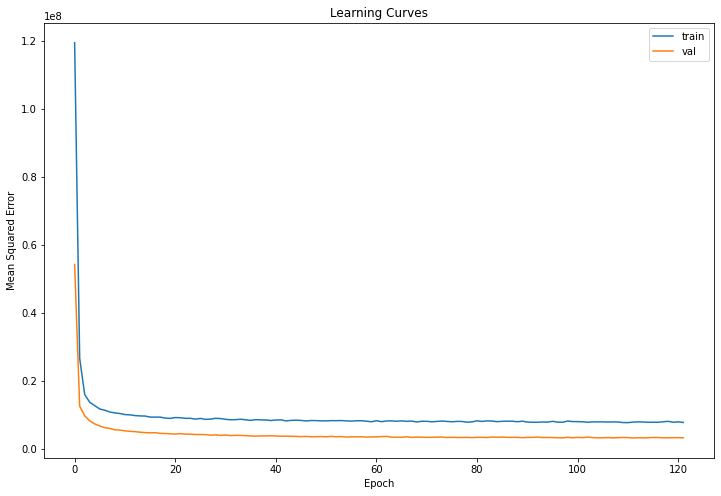

Train RMSE: 1806.822, Train MAPE: 10.295 

Val RMSE: 1760.701, Val MAPE: 10.128 

Test RMSE: 1778.050, Test MAPE: 10.283 

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_198 (Dense)            (None, 64)                3392      
_________________________________________________________________
dropout_94 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_199 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_95 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_200 (Dense)            (None, 1)                 65        
Total params: 7,617
Trainable params: 7,617
Non-trainable params: 0
____________________________________________________________

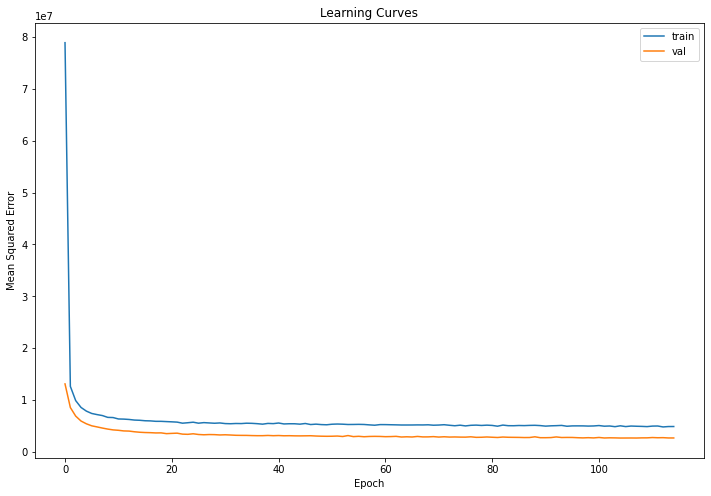

Train RMSE: 1619.981, Train MAPE: 9.219 

Val RMSE: 1602.932, Val MAPE: 9.197 

Test RMSE: 1607.740, Test MAPE: 9.306 

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_201 (Dense)            (None, 128)               6784      
_________________________________________________________________
dropout_96 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_202 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_97 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_203 (Dense)            (None, 1)                 129       
Total params: 23,425
Trainable params: 23,425
Non-trainable params: 0
_____________________________________________________________

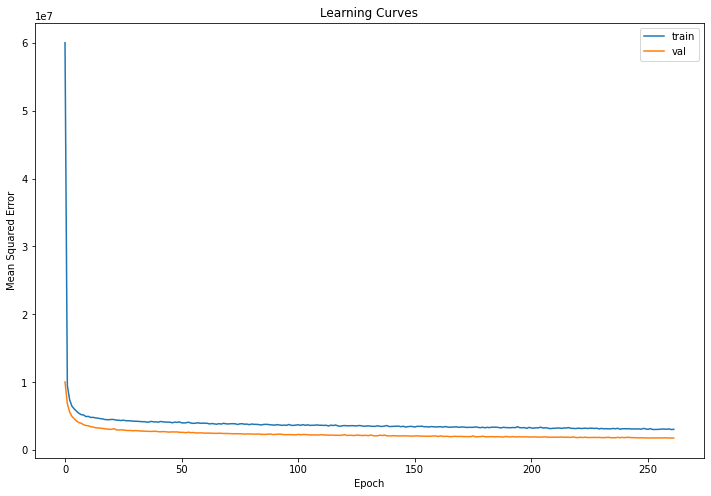

Train RMSE: 1287.833, Train MAPE: 7.424 

Val RMSE: 1298.139, Val MAPE: 7.515 

Test RMSE: 1301.819, Test MAPE: 7.627 

Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_204 (Dense)            (None, 256)               13568     
_________________________________________________________________
dropout_98 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_205 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_99 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_206 (Dense)            (None, 1)                 257       
Total params: 79,617
Trainable params: 79,617
Non-trainable params: 0
_____________________________________________________________

Train RMSE: 1163.687, Train MAPE: 6.683 

Val RMSE: 1180.801, Val MAPE: 6.865 

Test RMSE: 1195.911, Test MAPE: 6.971 

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_207 (Dense)            (None, 512)               27136     
_________________________________________________________________
dropout_100 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_208 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_101 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_209 (Dense)            (None, 1)                 513       
Total params: 290,305
Trainable params: 290,305
Non-trainable params: 0
___________________________________________________________

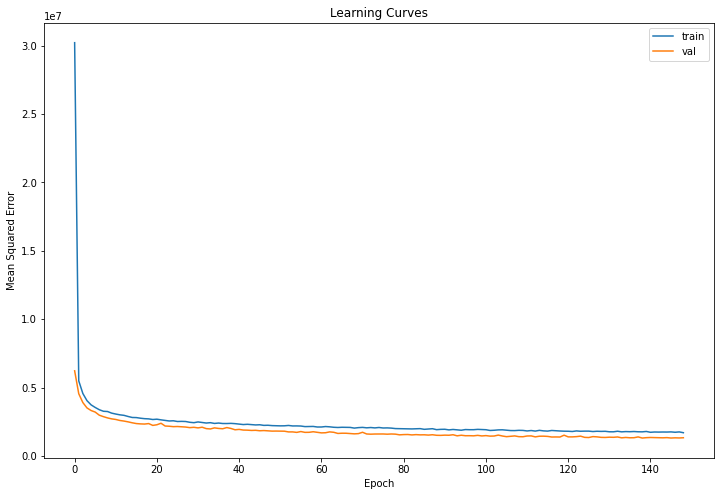

Train RMSE: 1069.958, Train MAPE: 6.311 

Val RMSE: 1109.470, Val MAPE: 6.597 

Test RMSE: 1116.725, Test MAPE: 6.668 

Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_210 (Dense)            (None, 16)                848       
_________________________________________________________________
dropout_102 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_211 (Dense)            (None, 8)                 136       
_________________________________________________________________
dropout_103 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_212 (Dense)            (None, 1)                 9         
Total params: 993
Trainable params: 993
Non-trainable params: 0
_________________________________________________________________
N

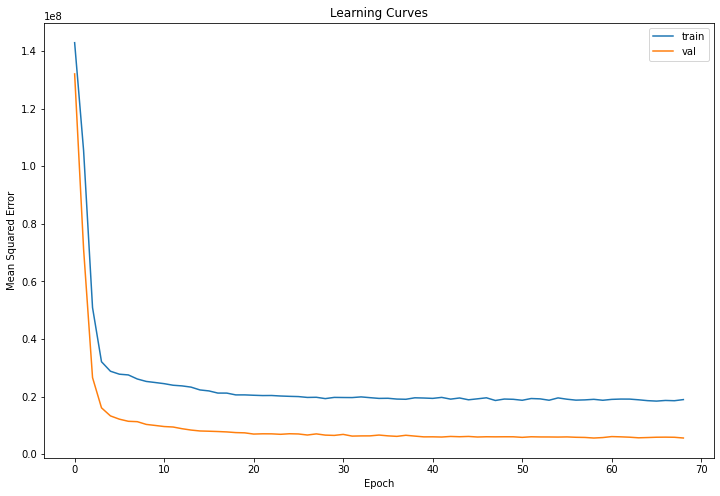

Train RMSE: 2324.113, Train MAPE: 12.927 

Val RMSE: 2258.352, Val MAPE: 12.749 

Test RMSE: 2282.077, Test MAPE: 12.932 

Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_213 (Dense)            (None, 32)                1696      
_________________________________________________________________
dropout_104 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_214 (Dense)            (None, 16)                528       
_________________________________________________________________
dropout_105 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_215 (Dense)            (None, 1)                 17        
Total params: 2,241
Trainable params: 2,241
Non-trainable params: 0
____________________________________________________________

Train RMSE: 1943.947, Train MAPE: 11.102 

Val RMSE: 1891.162, Val MAPE: 10.942 

Test RMSE: 1910.989, Test MAPE: 11.086 

Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_216 (Dense)            (None, 64)                3392      
_________________________________________________________________
dropout_106 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_217 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_107 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_218 (Dense)            (None, 1)                 33        
Total params: 5,505
Trainable params: 5,505
Non-trainable params: 0
____________________________________________________________

Train RMSE: 1673.052, Train MAPE: 9.394 

Val RMSE: 1645.976, Val MAPE: 9.349 

Test RMSE: 1654.417, Test MAPE: 9.469 

Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_219 (Dense)            (None, 128)               6784      
_________________________________________________________________
dropout_108 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_220 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_109 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_221 (Dense)            (None, 1)                 65        
Total params: 15,105
Trainable params: 15,105
Non-trainable params: 0
_____________________________________________________________

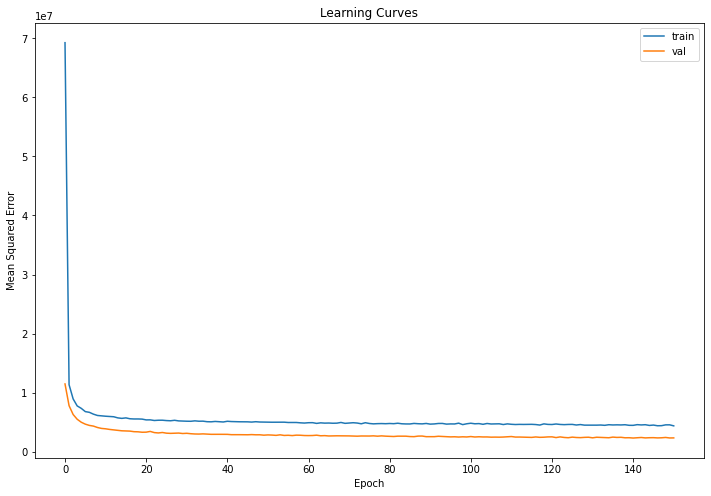

Train RMSE: 1489.315, Train MAPE: 8.323 

Val RMSE: 1482.495, Val MAPE: 8.379 

Test RMSE: 1480.494, Test MAPE: 8.490 

Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_222 (Dense)            (None, 256)               13568     
_________________________________________________________________
dropout_110 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_223 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_111 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_224 (Dense)            (None, 1)                 129       
Total params: 46,593
Trainable params: 46,593
Non-trainable params: 0
_____________________________________________________________

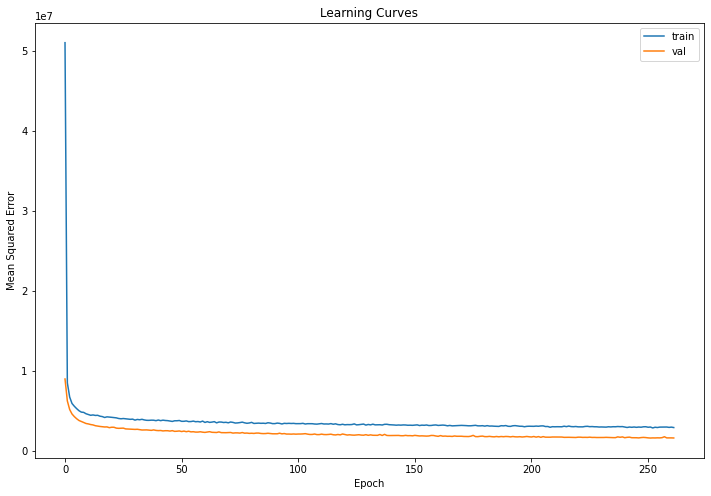

Train RMSE: 1199.150, Train MAPE: 6.954 

Val RMSE: 1220.507, Val MAPE: 7.096 

Test RMSE: 1230.486, Test MAPE: 7.228 

Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_225 (Dense)            (None, 512)               27136     
_________________________________________________________________
dropout_112 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_226 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_113 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_227 (Dense)            (None, 1)                 257       
Total params: 158,721
Trainable params: 158,721
Non-trainable params: 0
___________________________________________________________

Train RMSE: 1180.236, Train MAPE: 7.206 

Val RMSE: 1210.578, Val MAPE: 7.429 

Test RMSE: 1205.964, Test MAPE: 7.461 

Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_228 (Dense)            (None, 8)                 424       
_________________________________________________________________
batch_normalization_38 (Batc (None, 8)                 32        
_________________________________________________________________
dense_229 (Dense)            (None, 16)                144       
_________________________________________________________________
dropout_114 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_230 (Dense)            (None, 1)                 17        
Total params: 617
Trainable params: 601
Non-trainable params: 16
_________________________________________________________________


Train RMSE: 2045.773, Train MAPE: 11.796 

Val RMSE: 2022.384, Val MAPE: 11.774 

Test RMSE: 2034.773, Test MAPE: 11.834 

Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_231 (Dense)            (None, 16)                848       
_________________________________________________________________
batch_normalization_39 (Batc (None, 16)                64        
_________________________________________________________________
dense_232 (Dense)            (None, 32)                544       
_________________________________________________________________
dropout_115 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_233 (Dense)            (None, 1)                 33        
Total params: 1,489
Trainable params: 1,457
Non-trainable params: 32
___________________________________________________________

Train RMSE: 1539.553, Train MAPE: 9.189 

Val RMSE: 1570.349, Val MAPE: 9.362 

Test RMSE: 1561.376, Test MAPE: 9.394 

Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_234 (Dense)            (None, 32)                1696      
_________________________________________________________________
batch_normalization_40 (Batc (None, 32)                128       
_________________________________________________________________
dense_235 (Dense)            (None, 64)                2112      
_________________________________________________________________
dropout_116 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_236 (Dense)            (None, 1)                 65        
Total params: 4,001
Trainable params: 3,937
Non-trainable params: 64
______________________________________________________________

Train RMSE: 1598.816, Train MAPE: 8.848 

Val RMSE: 1602.478, Val MAPE: 8.815 

Test RMSE: 1584.831, Test MAPE: 8.846 

Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_237 (Dense)            (None, 64)                3392      
_________________________________________________________________
batch_normalization_41 (Batc (None, 64)                256       
_________________________________________________________________
dense_238 (Dense)            (None, 128)               8320      
_________________________________________________________________
dropout_117 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_239 (Dense)            (None, 1)                 129       
Total params: 12,097
Trainable params: 11,969
Non-trainable params: 128
___________________________________________________________

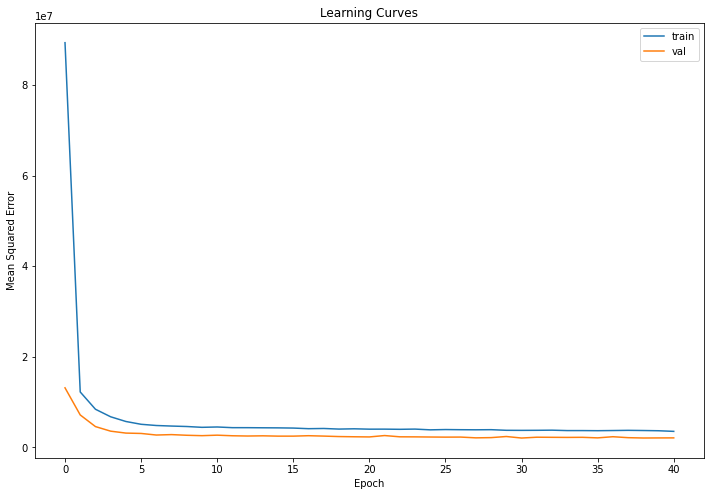

Train RMSE: 1419.234, Train MAPE: 7.854 

Val RMSE: 1444.512, Val MAPE: 7.919 

Test RMSE: 1407.375, Test MAPE: 7.978 

Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_240 (Dense)            (None, 128)               6784      
_________________________________________________________________
batch_normalization_42 (Batc (None, 128)               512       
_________________________________________________________________
dense_241 (Dense)            (None, 256)               33024     
_________________________________________________________________
dropout_118 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_242 (Dense)            (None, 1)                 257       
Total params: 40,577
Trainable params: 40,321
Non-trainable params: 256
___________________________________________________________

Train RMSE: 1212.603, Train MAPE: 6.915 

Val RMSE: 1236.508, Val MAPE: 7.128 

Test RMSE: 1246.741, Test MAPE: 7.238 

Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_243 (Dense)            (None, 256)               13568     
_________________________________________________________________
batch_normalization_43 (Batc (None, 256)               1024      
_________________________________________________________________
dense_244 (Dense)            (None, 512)               131584    
_________________________________________________________________
dropout_119 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_245 (Dense)            (None, 1)                 513       
Total params: 146,689
Trainable params: 146,177
Non-trainable params: 512
_________________________________________________________

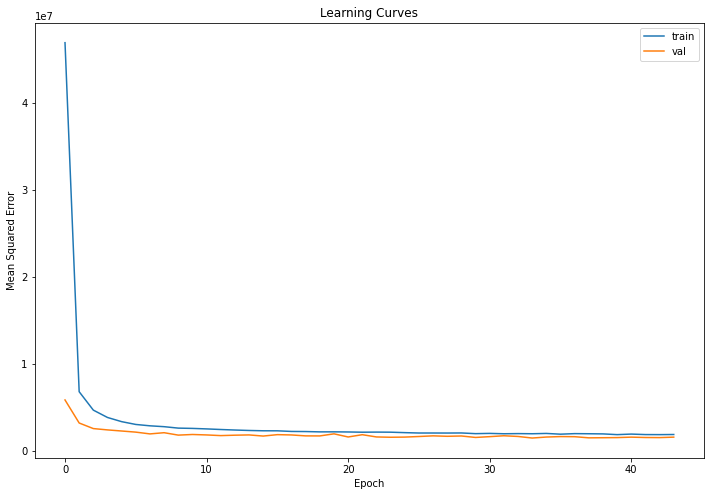

Train RMSE: 1219.190, Train MAPE: 6.668 

Val RMSE: 1373.937, Val MAPE: 7.034 

Test RMSE: 1289.497, Test MAPE: 6.979 

Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_246 (Dense)            (None, 8)                 424       
_________________________________________________________________
batch_normalization_44 (Batc (None, 8)                 32        
_________________________________________________________________
dense_247 (Dense)            (None, 8)                 72        
_________________________________________________________________
dropout_120 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_248 (Dense)            (None, 1)                 9         
Total params: 537
Trainable params: 521
Non-trainable params: 16
_________________________________________________________________


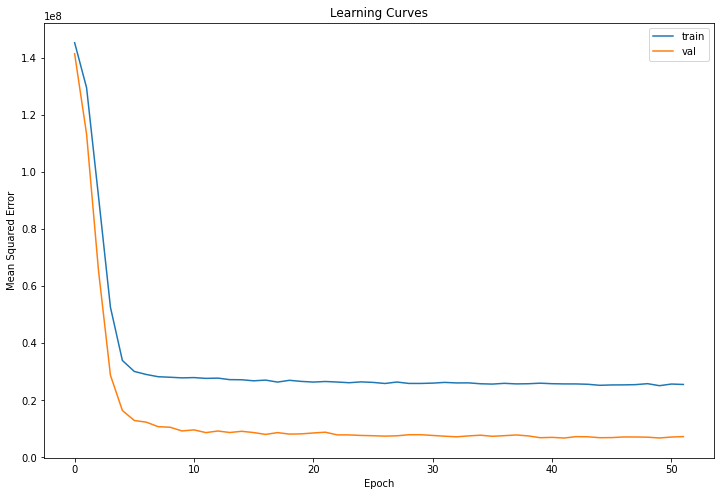

Train RMSE: 2690.841, Train MAPE: 17.923 

Val RMSE: 2681.149, Val MAPE: 18.104 

Test RMSE: 2672.632, Test MAPE: 17.904 

Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_249 (Dense)            (None, 16)                848       
_________________________________________________________________
batch_normalization_45 (Batc (None, 16)                64        
_________________________________________________________________
dense_250 (Dense)            (None, 16)                272       
_________________________________________________________________
dropout_121 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_251 (Dense)            (None, 1)                 17        
Total params: 1,201
Trainable params: 1,169
Non-trainable params: 32
___________________________________________________________

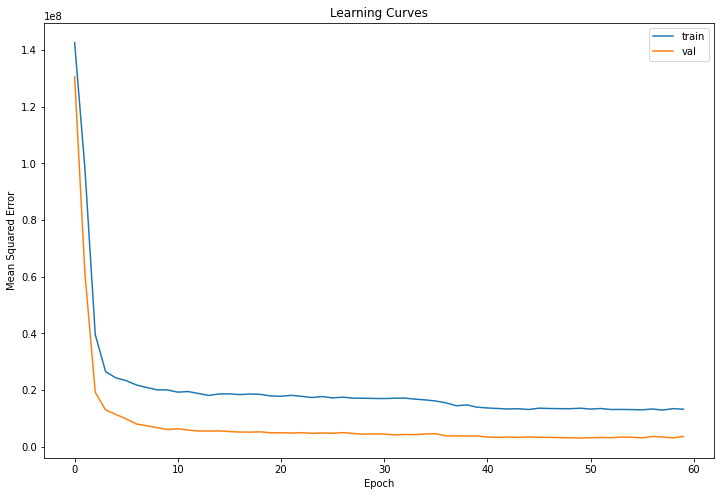

Train RMSE: 1873.011, Train MAPE: 10.991 

Val RMSE: 1857.420, Val MAPE: 11.056 

Test RMSE: 1876.082, Test MAPE: 11.094 

Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_252 (Dense)            (None, 32)                1696      
_________________________________________________________________
batch_normalization_46 (Batc (None, 32)                128       
_________________________________________________________________
dense_253 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_122 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_254 (Dense)            (None, 1)                 33        
Total params: 2,913
Trainable params: 2,849
Non-trainable params: 64
___________________________________________________________

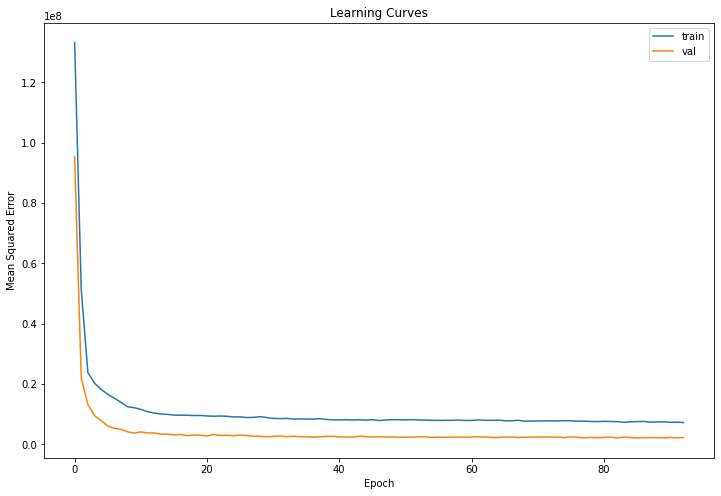

Train RMSE: 1457.584, Train MAPE: 8.174 

Val RMSE: 1472.004, Val MAPE: 8.249 

Test RMSE: 1434.473, Test MAPE: 8.307 

Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_255 (Dense)            (None, 64)                3392      
_________________________________________________________________
batch_normalization_47 (Batc (None, 64)                256       
_________________________________________________________________
dense_256 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_123 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_257 (Dense)            (None, 1)                 65        
Total params: 7,873
Trainable params: 7,745
Non-trainable params: 128
_____________________________________________________________

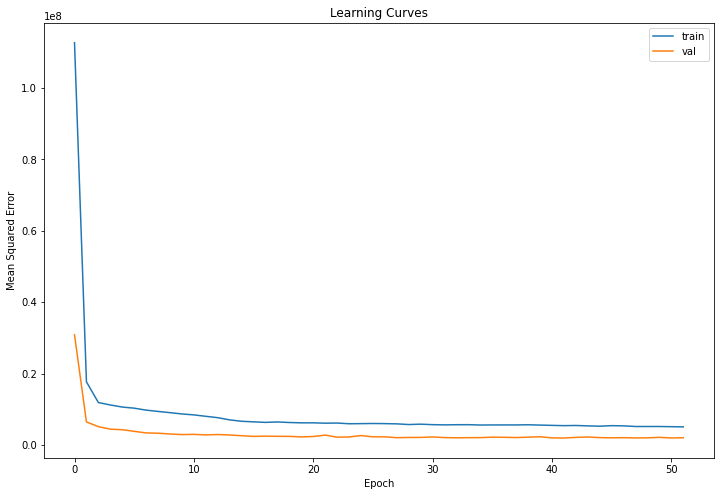

Train RMSE: 1387.369, Train MAPE: 8.178 

Val RMSE: 1424.898, Val MAPE: 8.381 

Test RMSE: 1388.151, Test MAPE: 8.307 

Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_258 (Dense)            (None, 128)               6784      
_________________________________________________________________
batch_normalization_48 (Batc (None, 128)               512       
_________________________________________________________________
dense_259 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_124 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_260 (Dense)            (None, 1)                 129       
Total params: 23,937
Trainable params: 23,681
Non-trainable params: 256
___________________________________________________________

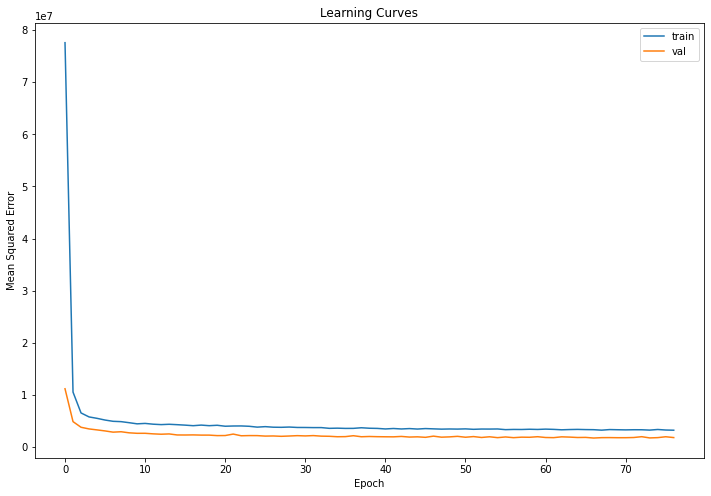

Train RMSE: 1323.921, Train MAPE: 7.216 

Val RMSE: 1376.667, Val MAPE: 7.276 

Test RMSE: 1381.381, Test MAPE: 7.423 

Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_261 (Dense)            (None, 256)               13568     
_________________________________________________________________
batch_normalization_49 (Batc (None, 256)               1024      
_________________________________________________________________
dense_262 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_125 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_263 (Dense)            (None, 1)                 257       
Total params: 80,641
Trainable params: 80,129
Non-trainable params: 512
___________________________________________________________

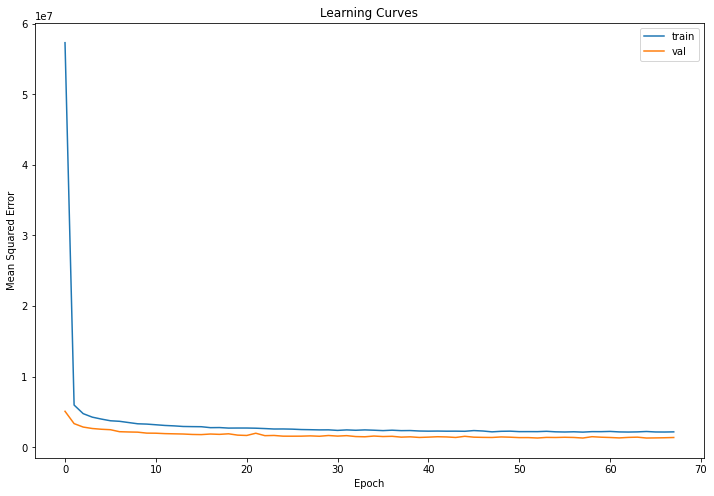

Train RMSE: 1116.079, Train MAPE: 6.286 

Val RMSE: 1139.393, Val MAPE: 6.506 

Test RMSE: 1159.069, Test MAPE: 6.685 

Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_264 (Dense)            (None, 512)               27136     
_________________________________________________________________
batch_normalization_50 (Batc (None, 512)               2048      
_________________________________________________________________
dense_265 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_126 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_266 (Dense)            (None, 1)                 513       
Total params: 292,353
Trainable params: 291,329
Non-trainable params: 1,024
_______________________________________________________

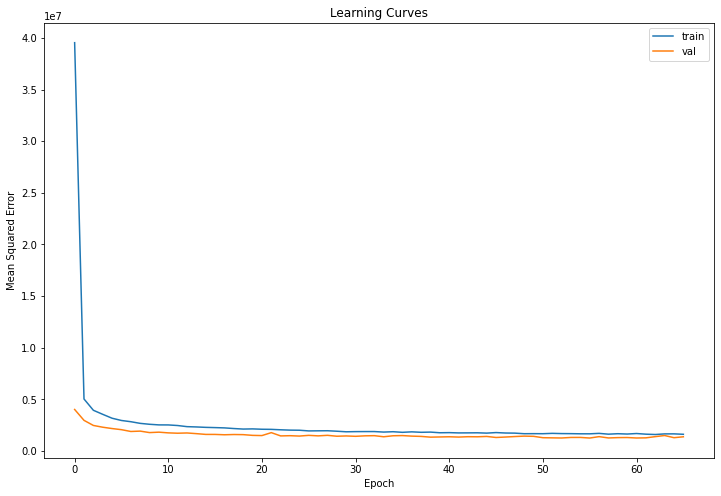

Train RMSE: 1068.266, Train MAPE: 6.308 

Val RMSE: 1100.527, Val MAPE: 6.590 

Test RMSE: 1136.504, Test MAPE: 6.604 

Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_267 (Dense)            (None, 16)                848       
_________________________________________________________________
batch_normalization_51 (Batc (None, 16)                64        
_________________________________________________________________
dense_268 (Dense)            (None, 8)                 136       
_________________________________________________________________
dropout_127 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_269 (Dense)            (None, 1)                 9         
Total params: 1,057
Trainable params: 1,025
Non-trainable params: 32
______________________________________________________________

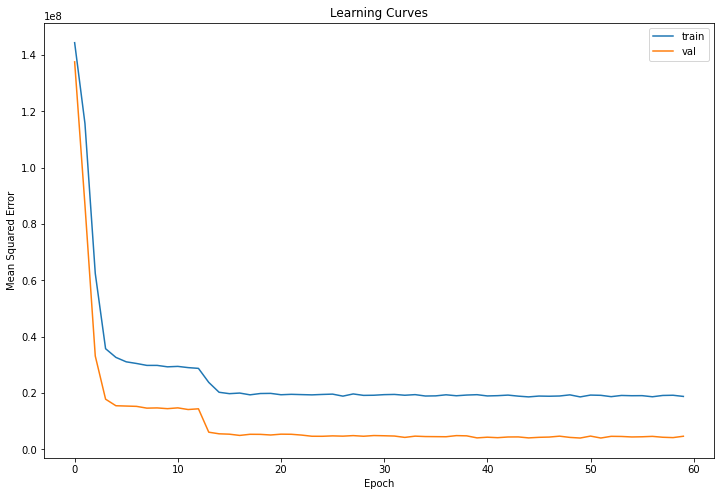

Train RMSE: 2099.822, Train MAPE: 12.339 

Val RMSE: 2061.003, Val MAPE: 12.270 

Test RMSE: 2082.755, Test MAPE: 12.407 

Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_270 (Dense)            (None, 32)                1696      
_________________________________________________________________
batch_normalization_52 (Batc (None, 32)                128       
_________________________________________________________________
dense_271 (Dense)            (None, 16)                528       
_________________________________________________________________
dropout_128 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_272 (Dense)            (None, 1)                 17        
Total params: 2,369
Trainable params: 2,305
Non-trainable params: 64
___________________________________________________________

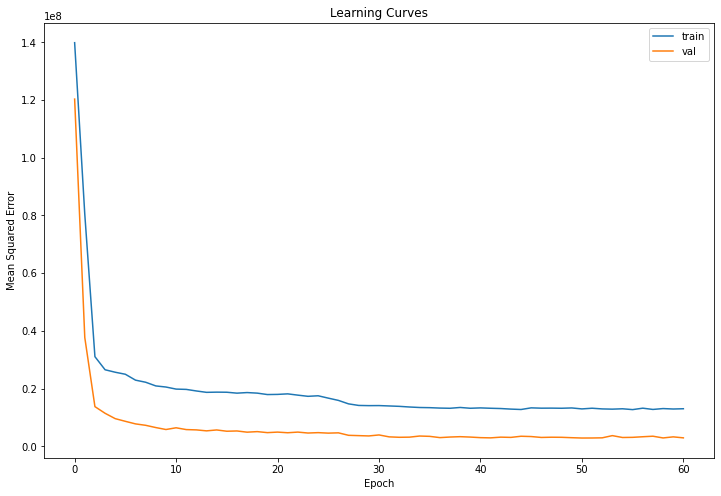

Train RMSE: 1668.627, Train MAPE: 9.783 

Val RMSE: 1664.420, Val MAPE: 9.893 

Test RMSE: 1674.915, Test MAPE: 9.969 

Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_273 (Dense)            (None, 64)                3392      
_________________________________________________________________
batch_normalization_53 (Batc (None, 64)                256       
_________________________________________________________________
dense_274 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_129 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_275 (Dense)            (None, 1)                 33        
Total params: 5,761
Trainable params: 5,633
Non-trainable params: 128
_____________________________________________________________

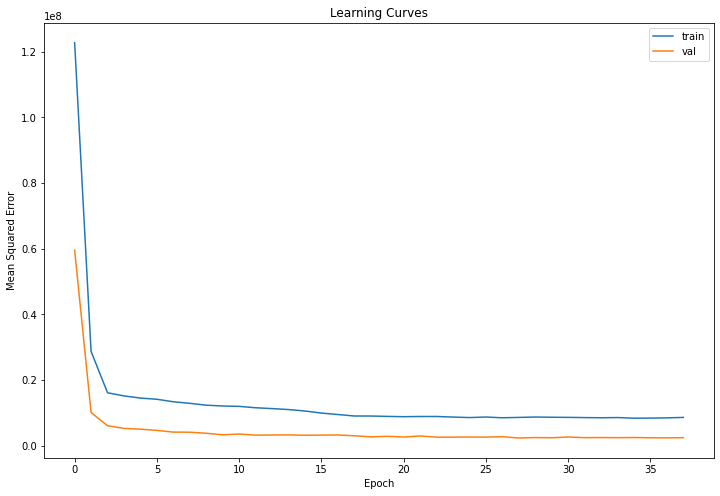

Train RMSE: 1527.262, Train MAPE: 8.749 

Val RMSE: 1515.170, Val MAPE: 8.778 

Test RMSE: 1526.617, Test MAPE: 8.864 

Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_276 (Dense)            (None, 128)               6784      
_________________________________________________________________
batch_normalization_54 (Batc (None, 128)               512       
_________________________________________________________________
dense_277 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_130 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_278 (Dense)            (None, 1)                 65        
Total params: 15,617
Trainable params: 15,361
Non-trainable params: 256
___________________________________________________________

Train RMSE: 1340.708, Train MAPE: 7.365 

Val RMSE: 1411.763, Val MAPE: 7.475 

Test RMSE: 1369.050, Test MAPE: 7.583 

Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_279 (Dense)            (None, 256)               13568     
_________________________________________________________________
batch_normalization_55 (Batc (None, 256)               1024      
_________________________________________________________________
dense_280 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_131 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_281 (Dense)            (None, 1)                 129       
Total params: 47,617
Trainable params: 47,105
Non-trainable params: 512
___________________________________________________________

Train RMSE: 1274.547, Train MAPE: 7.039 

Val RMSE: 1376.437, Val MAPE: 7.191 

Test RMSE: 1293.290, Test MAPE: 7.239 

Model: "sequential_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_282 (Dense)            (None, 512)               27136     
_________________________________________________________________
batch_normalization_56 (Batc (None, 512)               2048      
_________________________________________________________________
dense_283 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_132 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_284 (Dense)            (None, 1)                 257       
Total params: 160,769
Trainable params: 159,745
Non-trainable params: 1,024
_______________________________________________________

Train RMSE: 1189.948, Train MAPE: 6.714 

Val RMSE: 1239.158, Val MAPE: 6.951 

Test RMSE: 1245.088, Test MAPE: 6.993 

Model: "sequential_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_285 (Dense)            (None, 8)                 424       
_________________________________________________________________
dropout_133 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_286 (Dense)            (None, 16)                144       
_________________________________________________________________
dropout_134 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_287 (Dense)            (None, 1)                 17        
Total params: 585
Trainable params: 585
Non-trainable params: 0
_________________________________________________________________
N

Train RMSE: 2270.873, Train MAPE: 12.772 

Val RMSE: 2211.219, Val MAPE: 12.600 

Test RMSE: 2226.251, Test MAPE: 12.789 

Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_288 (Dense)            (None, 16)                848       
_________________________________________________________________
dropout_135 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_289 (Dense)            (None, 32)                544       
_________________________________________________________________
dropout_136 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_290 (Dense)            (None, 1)                 33        
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
____________________________________________________________

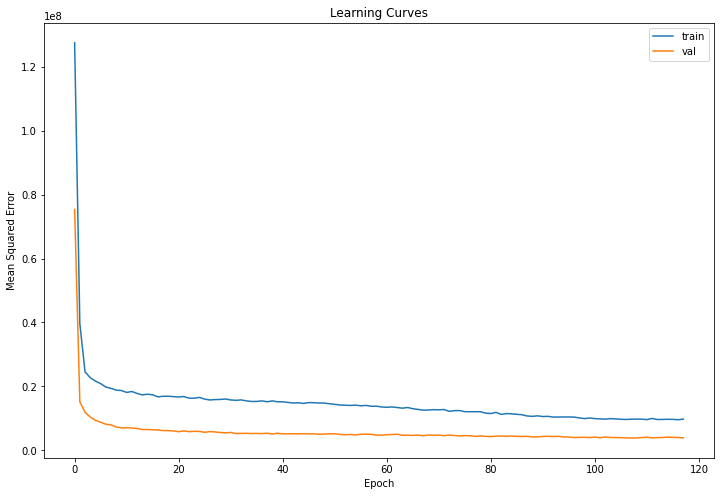

Train RMSE: 1953.062, Train MAPE: 11.561 

Val RMSE: 1903.073, Val MAPE: 11.394 

Test RMSE: 1914.694, Test MAPE: 11.542 

Model: "sequential_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_291 (Dense)            (None, 32)                1696      
_________________________________________________________________
dropout_137 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_292 (Dense)            (None, 64)                2112      
_________________________________________________________________
dropout_138 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_293 (Dense)            (None, 1)                 65        
Total params: 3,873
Trainable params: 3,873
Non-trainable params: 0
____________________________________________________________

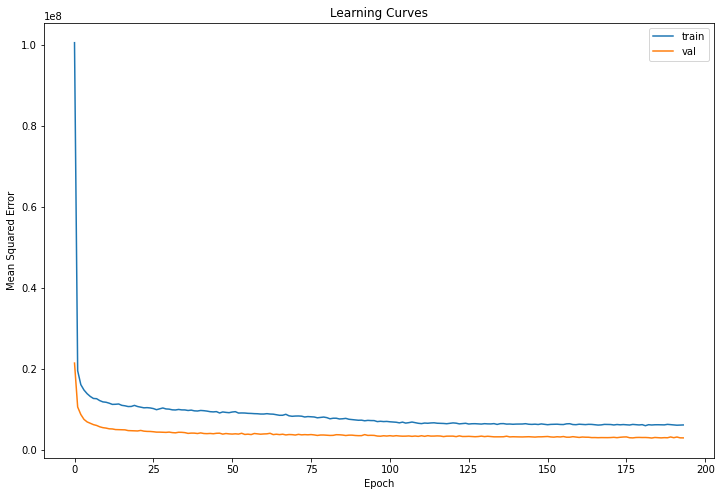

Train RMSE: 1681.095, Train MAPE: 10.301 

Val RMSE: 1657.254, Val MAPE: 10.272 

Test RMSE: 1661.729, Test MAPE: 10.371 

Model: "sequential_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_294 (Dense)            (None, 64)                3392      
_________________________________________________________________
dropout_139 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_295 (Dense)            (None, 128)               8320      
_________________________________________________________________
dropout_140 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_296 (Dense)            (None, 1)                 129       
Total params: 11,841
Trainable params: 11,841
Non-trainable params: 0
__________________________________________________________

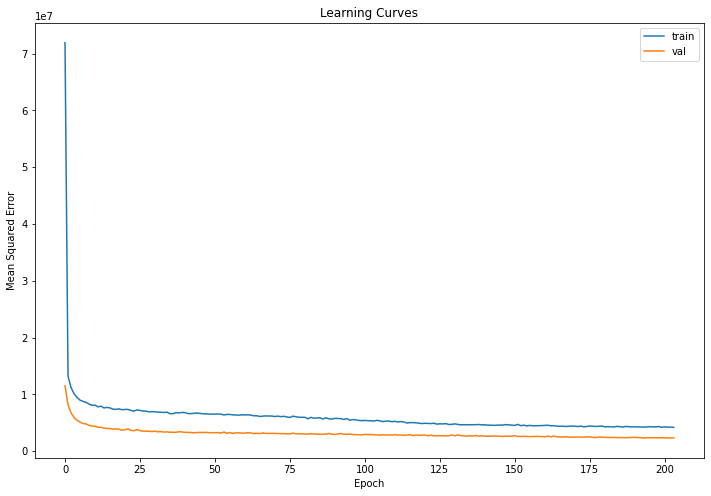

Train RMSE: 1487.278, Train MAPE: 8.681 

Val RMSE: 1471.765, Val MAPE: 8.661 

Test RMSE: 1477.460, Test MAPE: 8.802 

Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_297 (Dense)            (None, 128)               6784      
_________________________________________________________________
dropout_141 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_298 (Dense)            (None, 256)               33024     
_________________________________________________________________
dropout_142 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_299 (Dense)            (None, 1)                 257       
Total params: 40,065
Trainable params: 40,065
Non-trainable params: 0
_____________________________________________________________

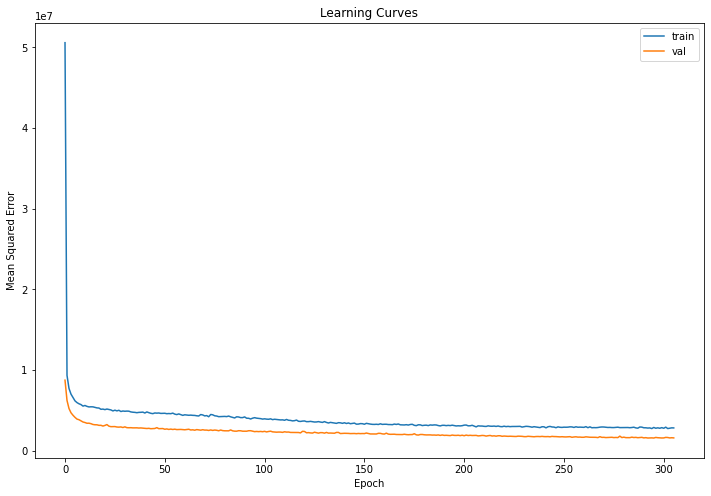

Train RMSE: 1223.475, Train MAPE: 7.285 

Val RMSE: 1251.736, Val MAPE: 7.365 

Test RMSE: 1254.121, Test MAPE: 7.507 

Model: "sequential_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_300 (Dense)            (None, 256)               13568     
_________________________________________________________________
dropout_143 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_301 (Dense)            (None, 512)               131584    
_________________________________________________________________
dropout_144 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_302 (Dense)            (None, 1)                 513       
Total params: 145,665
Trainable params: 145,665
Non-trainable params: 0
__________________________________________________________

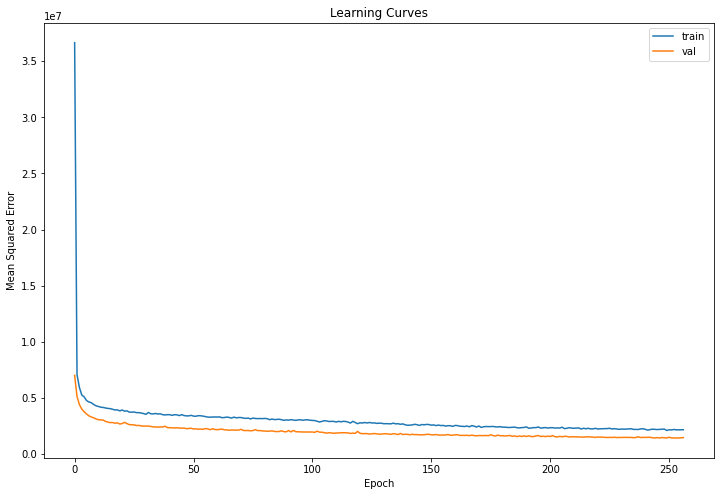

Train RMSE: 1141.468, Train MAPE: 6.751 

Val RMSE: 1176.417, Val MAPE: 6.901 

Test RMSE: 1176.558, Test MAPE: 7.023 

Model: "sequential_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_303 (Dense)            (None, 8)                 424       
_________________________________________________________________
dropout_145 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_304 (Dense)            (None, 8)                 72        
_________________________________________________________________
dropout_146 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_305 (Dense)            (None, 1)                 9         
Total params: 505
Trainable params: 505
Non-trainable params: 0
_________________________________________________________________


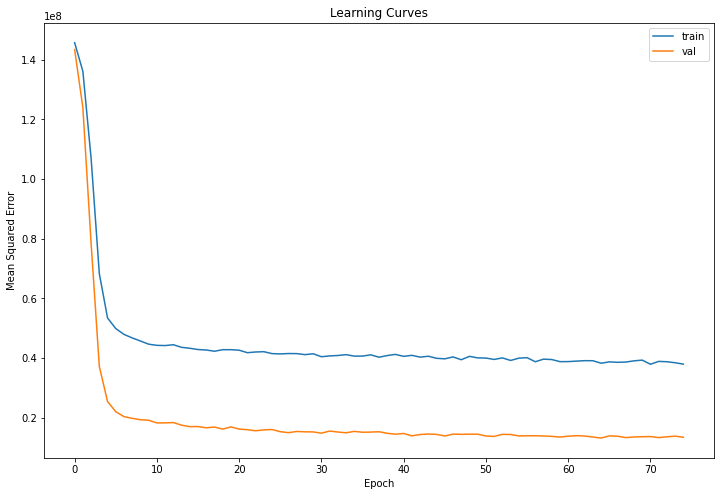

Train RMSE: 3640.002, Train MAPE: 23.169 

Val RMSE: 3576.588, Val MAPE: 23.014 

Test RMSE: 3606.864, Test MAPE: 23.256 

Model: "sequential_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_306 (Dense)            (None, 16)                848       
_________________________________________________________________
dropout_147 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_307 (Dense)            (None, 16)                272       
_________________________________________________________________
dropout_148 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_308 (Dense)            (None, 1)                 17        
Total params: 1,137
Trainable params: 1,137
Non-trainable params: 0
___________________________________________________________

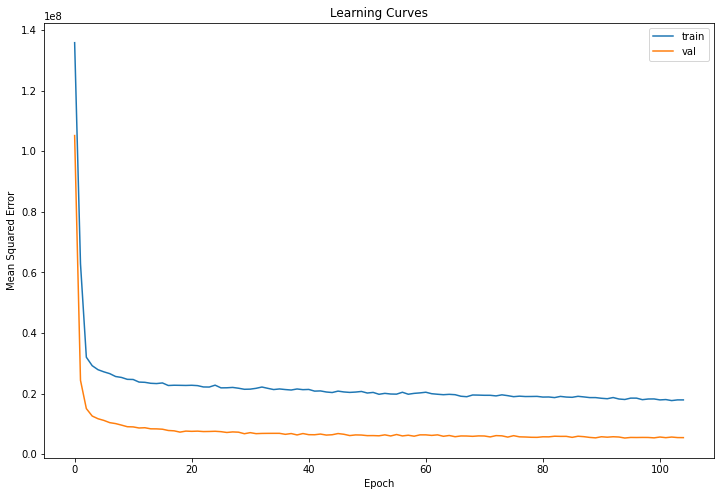

Train RMSE: 2307.830, Train MAPE: 12.801 

Val RMSE: 2243.032, Val MAPE: 12.624 

Test RMSE: 2267.100, Test MAPE: 12.803 

Model: "sequential_103"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_309 (Dense)            (None, 32)                1696      
_________________________________________________________________
dropout_149 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_310 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_150 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_311 (Dense)            (None, 1)                 33        
Total params: 2,785
Trainable params: 2,785
Non-trainable params: 0
___________________________________________________________

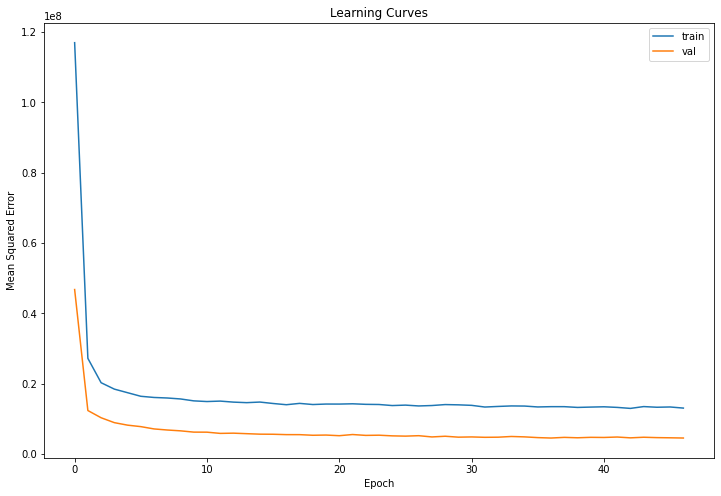

Train RMSE: 2096.640, Train MAPE: 11.949 

Val RMSE: 2030.072, Val MAPE: 11.726 

Test RMSE: 2053.806, Test MAPE: 11.917 

Model: "sequential_104"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_312 (Dense)            (None, 64)                3392      
_________________________________________________________________
dropout_151 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_313 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_152 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_314 (Dense)            (None, 1)                 65        
Total params: 7,617
Trainable params: 7,617
Non-trainable params: 0
___________________________________________________________

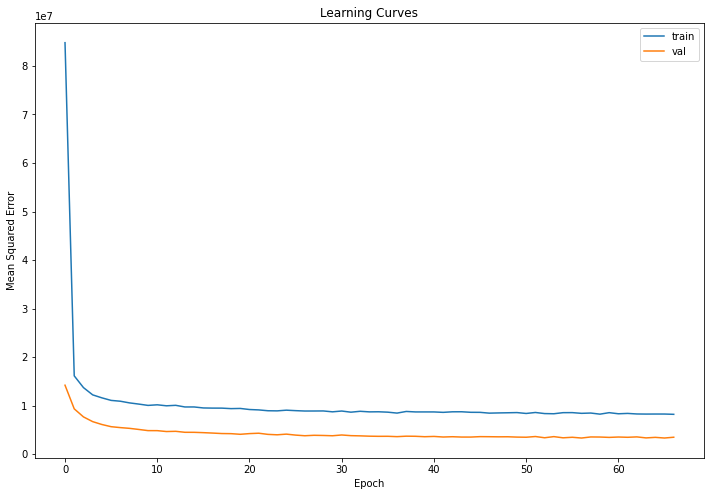

Train RMSE: 1843.203, Train MAPE: 10.397 

Val RMSE: 1796.324, Val MAPE: 10.271 

Test RMSE: 1813.796, Test MAPE: 10.401 

Model: "sequential_105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_315 (Dense)            (None, 128)               6784      
_________________________________________________________________
dropout_153 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_316 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_154 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_317 (Dense)            (None, 1)                 129       
Total params: 23,425
Trainable params: 23,425
Non-trainable params: 0
_________________________________________________________

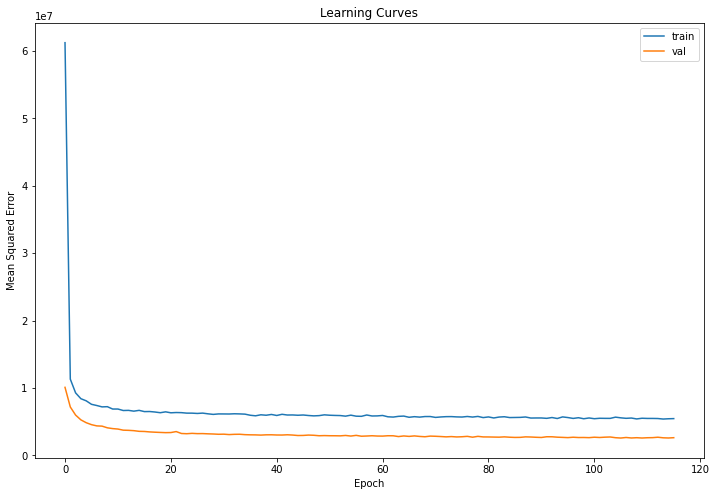

Train RMSE: 1592.107, Train MAPE: 8.885 

Val RMSE: 1573.973, Val MAPE: 8.878 

Test RMSE: 1570.032, Test MAPE: 8.973 

Model: "sequential_106"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_318 (Dense)            (None, 256)               13568     
_________________________________________________________________
dropout_155 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_319 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_156 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_320 (Dense)            (None, 1)                 257       
Total params: 79,617
Trainable params: 79,617
Non-trainable params: 0
____________________________________________________________

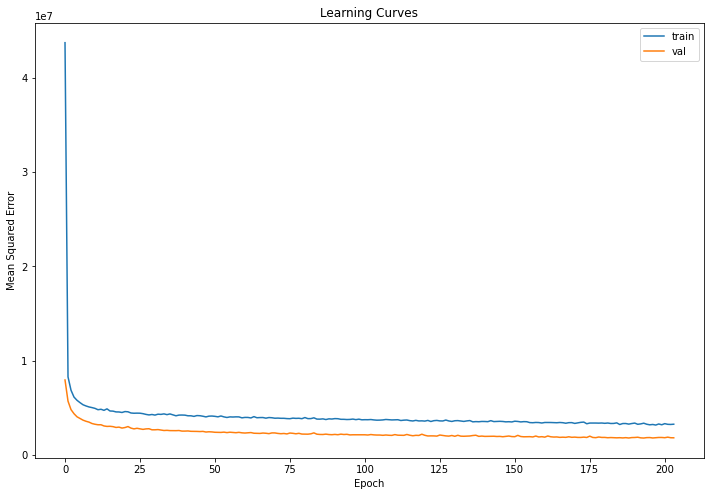

Train RMSE: 1296.384, Train MAPE: 7.431 

Val RMSE: 1307.030, Val MAPE: 7.497 

Test RMSE: 1307.403, Test MAPE: 7.622 

Model: "sequential_107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_321 (Dense)            (None, 512)               27136     
_________________________________________________________________
dropout_157 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_322 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_158 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_323 (Dense)            (None, 1)                 513       
Total params: 290,305
Trainable params: 290,305
Non-trainable params: 0
__________________________________________________________

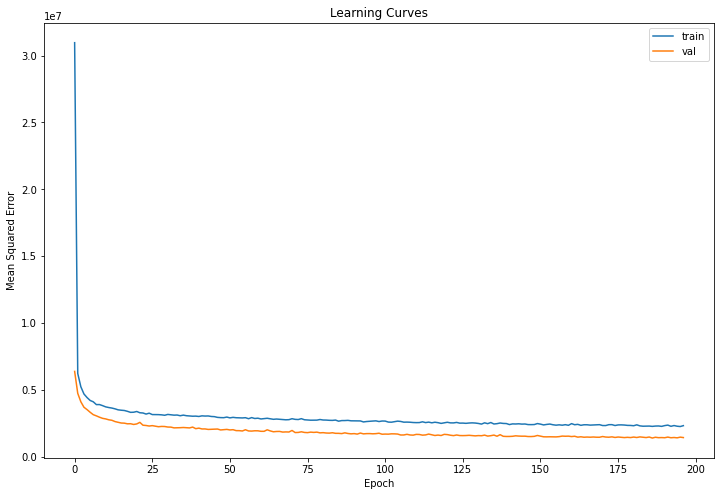

Train RMSE: 1130.943, Train MAPE: 6.799 

Val RMSE: 1159.706, Val MAPE: 6.985 

Test RMSE: 1169.293, Test MAPE: 7.110 

Model: "sequential_108"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_324 (Dense)            (None, 16)                848       
_________________________________________________________________
dropout_159 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_325 (Dense)            (None, 8)                 136       
_________________________________________________________________
dropout_160 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_326 (Dense)            (None, 1)                 9         
Total params: 993
Trainable params: 993
Non-trainable params: 0
_________________________________________________________________


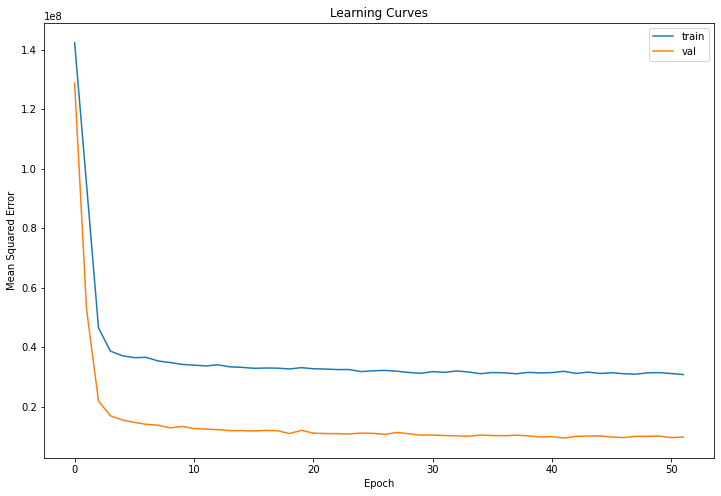

Train RMSE: 3082.814, Train MAPE: 18.434 

Val RMSE: 3014.118, Val MAPE: 18.244 

Test RMSE: 3045.117, Test MAPE: 18.527 

Model: "sequential_109"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_327 (Dense)            (None, 32)                1696      
_________________________________________________________________
dropout_161 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_328 (Dense)            (None, 16)                528       
_________________________________________________________________
dropout_162 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_329 (Dense)            (None, 1)                 17        
Total params: 2,241
Trainable params: 2,241
Non-trainable params: 0
___________________________________________________________

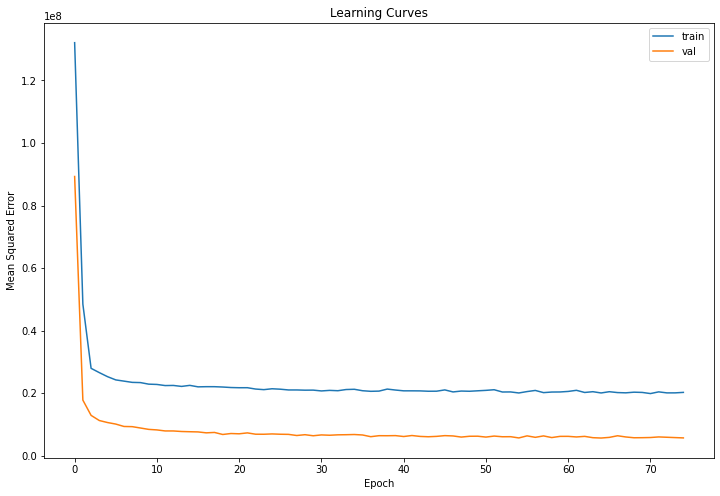

Train RMSE: 2353.536, Train MAPE: 13.294 

Val RMSE: 2285.705, Val MAPE: 13.126 

Test RMSE: 2310.614, Test MAPE: 13.318 

Model: "sequential_110"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_330 (Dense)            (None, 64)                3392      
_________________________________________________________________
dropout_163 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_331 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_164 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_332 (Dense)            (None, 1)                 33        
Total params: 5,505
Trainable params: 5,505
Non-trainable params: 0
___________________________________________________________

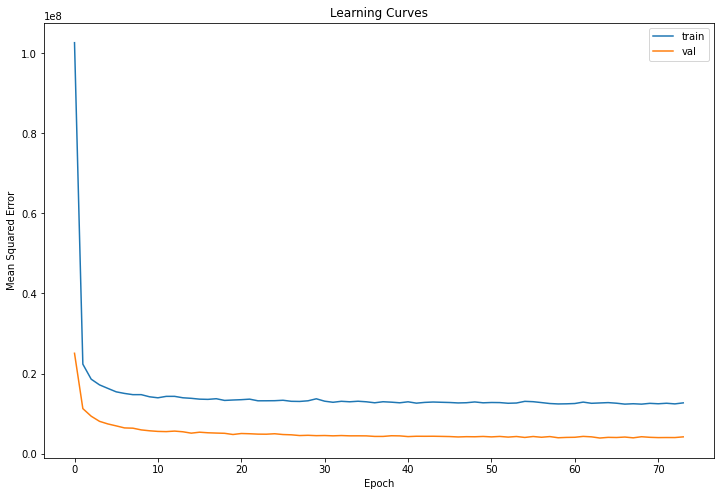

Train RMSE: 2017.170, Train MAPE: 11.407 

Val RMSE: 1961.074, Val MAPE: 11.255 

Test RMSE: 1982.250, Test MAPE: 11.413 

Model: "sequential_111"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_333 (Dense)            (None, 128)               6784      
_________________________________________________________________
dropout_165 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_334 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_166 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_335 (Dense)            (None, 1)                 65        
Total params: 15,105
Trainable params: 15,105
Non-trainable params: 0
_________________________________________________________

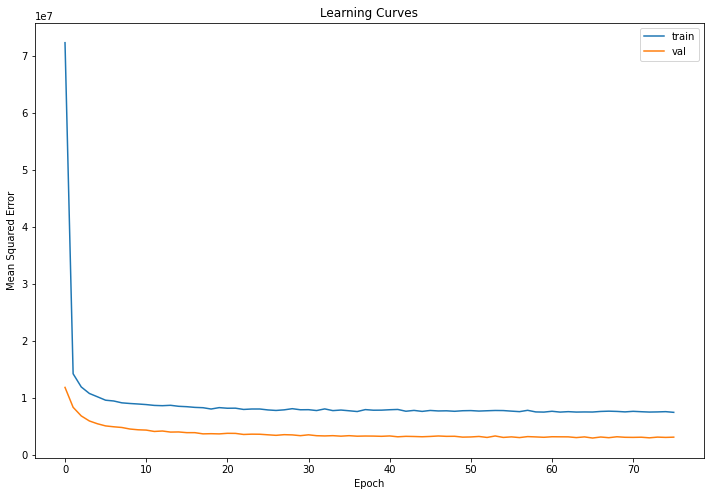

Train RMSE: 1742.669, Train MAPE: 9.721 

Val RMSE: 1704.546, Val MAPE: 9.679 

Test RMSE: 1717.625, Test MAPE: 9.789 

Model: "sequential_112"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_336 (Dense)            (None, 256)               13568     
_________________________________________________________________
dropout_167 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_337 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_168 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_338 (Dense)            (None, 1)                 129       
Total params: 46,593
Trainable params: 46,593
Non-trainable params: 0
____________________________________________________________

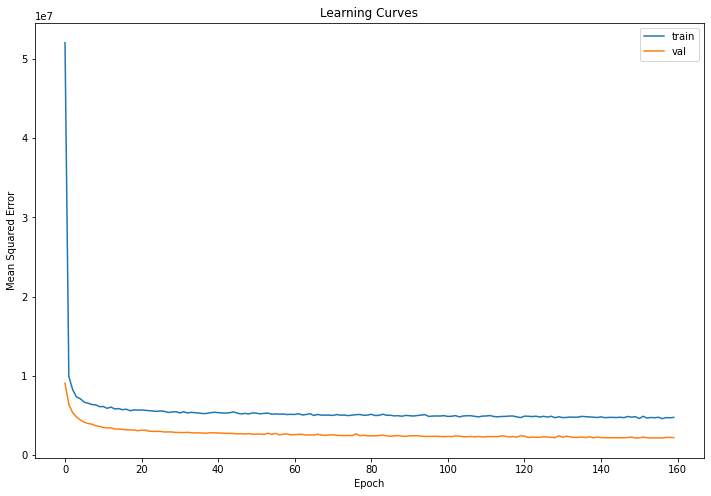

Train RMSE: 1446.928, Train MAPE: 8.117 

Val RMSE: 1445.904, Val MAPE: 8.186 

Test RMSE: 1452.135, Test MAPE: 8.284 

Model: "sequential_113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_339 (Dense)            (None, 512)               27136     
_________________________________________________________________
dropout_169 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_340 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_170 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_341 (Dense)            (None, 1)                 257       
Total params: 158,721
Trainable params: 158,721
Non-trainable params: 0
__________________________________________________________

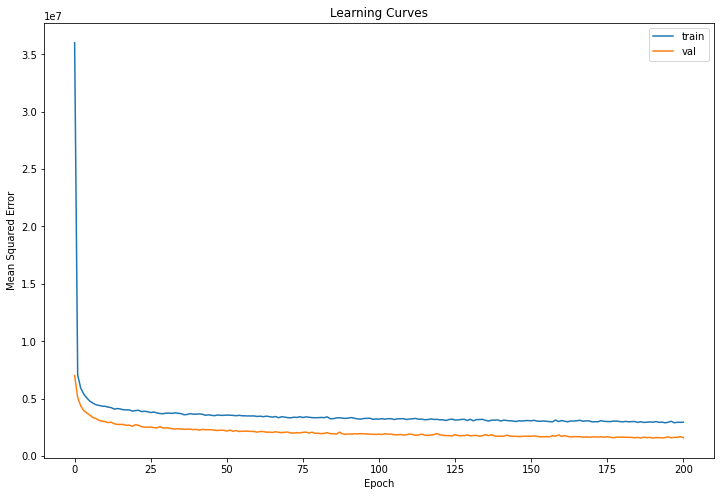

Train RMSE: 1207.393, Train MAPE: 7.017 

Val RMSE: 1224.305, Val MAPE: 7.166 

Test RMSE: 1231.432, Test MAPE: 7.271 



n_layer1  n_layer2  batch_norm  drop_rate   train_rmse    eval_rmse  \
0           8        16        True        0.2  1836.116211  1800.720093   
1          16        32        True        0.2  1419.066650  1415.617310   
2          32        64        True        0.2  1377.035278  1416.842651   
3          64       128        True        0.2  1309.983276  1345.398315   
4         128       256        True        0.2  1322.262207  1475.794922   
..        ...       ...         ...        ...          ...          ...   
109        32        16       False        0.5  2353.536133  2285.704590   
110        64        32       False        0.5  2017.170410  1961.073975   
111       128        64       False        0.5  1742.669067  1704.545776   
112       256       128       False        0.5  1446.928345  1445.903687   
113       512       256       False        0.5  1207.392944  1224.304565   

       test_rmse  train_mape  eval_mape  test_mape  
0    1817.247070   11.374303  11.347283  11.435469  
1    1436.649902    8.497251   8.394885   8.638517  
2    1375.264526    7.954701   8.094419   8.142742  
3    1310.690186    7.367060   7.506977   7.569656  
4    1442.844360    7.233266   7.452832   7.585454  
..           ...         ...        ...        ...  
109  2310.614014   13.294058  13.125543  13.318027  
110  1982.249512   11.407441  11.255345  11.412931  
111  1717.625366    9.721224   9.678530   9.788577  
112  1452.135010    8.117081   8.186202   8.284330  
113  1231.432495    7.017390   7.165880   7.270627  

[114 rows x 10 columns]

<Figure size 864x576 with 0 Axes>

In [11]:
df_results = pd.DataFrame()

param_grid = [(b, d) for d in [0.2, 0.3, 0.5] for b in [True, False]] # searching for best batch_norm and dropout_rate

for b, d in tqdm(param_grid):
    frame = model_training(batch_norm=b, drop_rate=d)
    df_results = pd.concat([df_results, frame], axis=0)
    
df_results.reset_index(drop=True, inplace=True)
df_results

# Saving Results

In [12]:
df_results.to_csv('two_layer_nn_results.csv', index=False)